In [1]:
"""
Trying Optimus 5' architecture for JTE607 polyA data
"""

import pandas as pd
import numpy as np
from numpy import ma
import matplotlib.pyplot as plt
from matplotlib import ticker
import scipy.stats as stats
import seaborn as sns
from sklearn import preprocessing
import random
import pickle
from collections import defaultdict
import os
import OSU
from toolz import interleave

#from tensorflow import keras
#import keras
import tensorflow as tf
np.random.seed(1337)

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Masking
from tensorflow.keras.optimizers import Adam

%matplotlib inline

### Parameters for plotting model results ###
pd.set_option("display.max_colwidth",100)
sns.set(style="ticks", color_codes=True)
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['axes.labelpad'] = 5
plt.rcParams['axes.linewidth']= 1.5
plt.rcParams['xtick.labelsize']= 14
plt.rcParams['ytick.labelsize']= 14
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['axes.edgecolor'] = 'black'


def weighted_poly_profile_model_mask(x, y, w, border_mode='same', inp_len=50, nodes=1, layers=1, filter_len=8, nbr_filters=40,
                dropout1=0, dropout2=0, dropout3=0, nb_epoch=3):
    model = Sequential()
    
    #model.add(Masking(mask_value=-1, input_shape=(inp_len, 4)))

    if layers >= 1:
        model.add(Conv1D(input_shape=(inp_len, 4), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.ReLU())
    if layers >= 2:
        model.add(Conv1D(input_shape=(inp_len, 1), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.ReLU())
        model.add(Dropout(dropout1))
    if layers >= 3:
        model.add(Conv1D(input_shape=(inp_len, 1), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.ReLU())
        model.add(Dropout(dropout2))
    model.add(Flatten())

    model.add(Dense(nodes))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(dropout3))
    
    model.add(Dense(y.shape[1]))

    #compile the model
    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)  # +- 100x scan for lr
    model.compile(loss='mean_squared_error', optimizer=adam, )

    model.fit(x, y, sample_weight=w*len(w), batch_size=64, epochs=nb_epoch, verbose=1)
    return model


def one_hot_encode(sequences, max_seq_len=164, mask_val=-1, padding='left'):
    # Dictionary returning one-hot encoding of nucleotides. 
    nuc_d = {'a':[1,0,0,0],
             'c':[0,1,0,0],
             'g':[0,0,1,0],
             't':[0,0,0,1],
             'n':[0,0,0,0],
            'm':[mask_val,mask_val,mask_val,mask_val]}
    
    # Creat empty matrix
    one_hot_seqs = np.ones([len(sequences), max_seq_len, 4])*mask_val
    
    # Iterate through sequences and one-hot encode
    for i, seq in enumerate(sequences):
        # Truncate
        seq = seq[:max_seq_len].lower()
        # Convert to array
        one_hot_seq = np.array([nuc_d[x] for x in seq])
        # Append to matrix
        if padding=='left':
            one_hot_seqs[i, :len(seq), :] = one_hot_seq
        elif padding=='right':
            one_hot_seqs[i, -len(seq):, :] = one_hot_seq
        else:
            ValueError(f'padding {padding} not recognized')
            
    return one_hot_seqs


def r2(x,y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return r_value**2

In [2]:
# Load JTE607 data from both backbones individually
# Filter based off of DMSO reads per variant
# Adds one to counts if there is a missing PAS from the list generated from DMSO. This is for log ratio.

# L3 loading and counting reads, filter away variants with < 50 reads in DMSO
#L3_shared_5p = "m"*5+"GCGAATTGGAGCTCTTCTTTTTGTCACTTGAAAAACATGTAAAAATAATGTACTAGGAGACACTTTCAATAAA"
#L3_shared_3p = "TCGGGTGATTATTTACCCCCCACCCTTGCCGTCTGCGAGAATTCGAT"+"m"*14  #masking right end here to line up hexamer
parsed_L3_cleaved_output_dir = "/JTE-607/Analysis/parsed_L3_input_RNA_clusterPASRandom_bbmerge_xloose/parsed_L3_cleaved_RNA_multimapping_mincov1_preload_bbmerge_xloose_H1shortN4indel/collapsed/"
polyA_L3_DMSO_cleaved_pickle = parsed_L3_cleaved_output_dir + "L3_DMSO_polya_pos_dict.pickle"
polyA_L3_0p5uM_cleaved_pickle = parsed_L3_cleaved_output_dir + "L3_0p5uM_polya_pos_dict.pickle"
polyA_L3_2p5uM_cleaved_pickle = parsed_L3_cleaved_output_dir + "L3_2p5uM_polya_pos_dict.pickle"
polyA_L3_12p5uM_cleaved_pickle = parsed_L3_cleaved_output_dir + "L3_12p5uM_polya_pos_dict.pickle"

L3_polyA_pos_pickle_dict = {"L3_DMSO": polyA_L3_DMSO_cleaved_pickle,\
              "L3_0p5uM": polyA_L3_0p5uM_cleaved_pickle,\
             "L3_2p5uM": polyA_L3_2p5uM_cleaved_pickle,\
              "L3_12p5uM": polyA_L3_12p5uM_cleaved_pickle}

L3_PAS_read_counts = defaultdict(int)
polya_pos_dict = pickle.load(open(polyA_L3_DMSO_cleaved_pickle, "rb"))
data_name = "L3_DMSO"
for curr_PAS, curr_polya_pos_count_dict in polya_pos_dict.items():
    curr_total_reads = sum(curr_polya_pos_count_dict.values())
    curr_PAS = curr_PAS.strip()
    if curr_total_reads >= 50:
        L3_PAS_read_counts[curr_PAS] += curr_total_reads

# SVLst loading and counting reads, filter away variants with < 100 reads in DMSO
#SVLst_shared_5p = "GCGAATTGGAGCTCATGCTTTATTTGTGAAATTTGTGATGCTATTGCTTTATTTGTAACCATTATAAGCTGCAATAAA"
#SVLst_shared_3p = "ATTTTATGTTTCAGGTTCAGGGGGAGGTGTGGGAGGTTTTTTAAAGCAAGTAGAATTCGAT"
parsed_SVLst_cleaved_output_dir = "/JTE-607/Analysis/parsed_SVLst_input_RNA_clusterPASRandom_bbmerge_xloose/parsed_SVLst_cleaved_RNA_multimapping_mincov1_preload_bbmerge_xloose_H1shortN4indel/collapsed/"
polyA_SVLst_DMSO_cleaved_pickle = parsed_SVLst_cleaved_output_dir + "SVLst_DMSO_polya_pos_dict.pickle"
polyA_SVLst_0p5uM_cleaved_pickle = parsed_SVLst_cleaved_output_dir + "SVLst_0p5uM_polya_pos_dict.pickle"
polyA_SVLst_2p5uM_cleaved_pickle = parsed_SVLst_cleaved_output_dir + "SVLst_2p5uM_polya_pos_dict.pickle"
polyA_SVLst_12p5uM_cleaved_pickle = parsed_SVLst_cleaved_output_dir + "SVLst_12p5uM_polya_pos_dict.pickle"

SVLst_polyA_pos_pickle_dict = {"SVLst_DMSO": polyA_SVLst_DMSO_cleaved_pickle,\
              "SVLst_0p5uM": polyA_SVLst_0p5uM_cleaved_pickle,\
             "SVLst_2p5uM": polyA_SVLst_2p5uM_cleaved_pickle,\
              "SVLst_12p5uM": polyA_SVLst_12p5uM_cleaved_pickle}

SVLst_PAS_read_counts = defaultdict(int)
SVLst_total_reads = 0
polya_pos_dict = pickle.load(open(polyA_SVLst_DMSO_cleaved_pickle, "rb"))
data_name = "SVLst_DMSO"
for curr_PAS, curr_polya_pos_count_dict in polya_pos_dict.items():
    curr_total_reads = sum(curr_polya_pos_count_dict.values())
    curr_PAS = curr_PAS.strip()
    if curr_total_reads >= 50:
        SVLst_PAS_read_counts[curr_PAS] += curr_total_reads

# combine L3 and SVLst, calculate percentages within each dataset
L3_PAS_percents_dict = {"L3_DMSO": None,\
              "L3_0p5uM": None,\
             "L3_2p5uM": None,\
              "L3_12p5uM": None}
SVLst_PAS_percents_dict = {"SVLst_DMSO": None,\
              "SVLst_0p5uM": None,\
             "SVLst_2p5uM": None,\
              "SVLst_12p5uM": None}

all_PAS = set()
for data_name, pickle_name in L3_polyA_pos_pickle_dict.items():
    polya_pos_dict = pickle.load(open(pickle_name, "rb"))
    PAS_read_counts = defaultdict(int)
    if set(polya_pos_dict.keys()).intersection(set(L3_PAS_read_counts.keys())) != set(L3_PAS_read_counts.keys()):
        add_one = True
        for curr_PAS in set(L3_PAS_read_counts.keys()) - set(polya_pos_dict.keys()):
            PAS_read_counts[curr_PAS] += 1
    else:
        add_one = False
    print("%s add_one = %s" % (data_name, add_one))
    for curr_PAS, curr_polya_pos_count_dict in polya_pos_dict.items():
        if curr_PAS in L3_PAS_read_counts:
            curr_total_reads = sum(curr_polya_pos_count_dict.values())
            #curr_PAS = L3_shared_5p + curr_PAS + L3_shared_3p
            PAS_read_counts[curr_PAS] += curr_total_reads
            if add_one:
                PAS_read_counts[curr_PAS] += 1
            all_PAS.add(curr_PAS)
    total_reads = float(sum(PAS_read_counts.values()))  # float for division later
    percentage_dict = {curr_PAS:(curr_read_count/total_reads) for curr_PAS, curr_read_count in PAS_read_counts.items()}
    df = pd.DataFrame(list(percentage_dict.items()),columns = ['PAS', data_name.split("_")[1] + '_percent'])
    L3_PAS_percents_dict[data_name] = df

for data_name, pickle_name in SVLst_polyA_pos_pickle_dict.items():
    polya_pos_dict = pickle.load(open(pickle_name, "rb"))
    PAS_read_counts = defaultdict(int)
    if set(polya_pos_dict.keys()).intersection(set(SVLst_PAS_read_counts.keys())) != set(SVLst_PAS_read_counts.keys()):
        add_one = True
        for curr_PAS in set(SVLst_PAS_read_counts.keys()) - set(polya_pos_dict.keys()):
            PAS_read_counts[curr_PAS] += 1
    else:
        add_one = False
    print("%s add_one = %s" % (data_name, add_one))
    for curr_PAS, curr_polya_pos_count_dict in polya_pos_dict.items():
        if curr_PAS in SVLst_PAS_read_counts:
            curr_total_reads = sum(curr_polya_pos_count_dict.values())
            #curr_PAS = SVLst_shared_5p + curr_PAS + SVLst_shared_3p
            PAS_read_counts[curr_PAS] += curr_total_reads
            if add_one:
                PAS_read_counts[curr_PAS] += 1
            all_PAS.add(curr_PAS)
    total_reads = float(sum(PAS_read_counts.values()))  # float for division later
    percentage_dict = {curr_PAS:(curr_read_count/total_reads) for curr_PAS, curr_read_count in PAS_read_counts.items()}
    df = pd.DataFrame(list(percentage_dict.items()),columns = ['PAS', data_name.split("_")[1] + '_percent'])
    SVLst_PAS_percents_dict[data_name] = df

print(len(all_PAS))
"""
merged_PAS_percentage_L3 = None
for data_name, curr_df in L3_PAS_percents_dict.items():
    if merged_PAS_percentage_L3 is None:
        merged_PAS_percentage_L3 = curr_df
    else:
        merged_PAS_percentage_L3 = merged_PAS_percentage_L3.merge(curr_df, how='outer', on="PAS")
merged_PAS_percentage_L3 = merged_PAS_percentage_L3.fillna(0)
print(merged_PAS_percentage_L3.shape)
print("Unsorted merged_PAS_percentage_L3: ", merged_PAS_percentage_L3)
merged_PAS_percentage_L3 = merged_PAS_percentage_L3.set_index("PAS")
merged_PAS_percentage_L3.reset_index(level=0, inplace=True)
merged_PAS_percentage_L3 = merged_PAS_percentage_L3.sort_values(by=["DMSO_percent"], ascending=False)
print("Sorted merged_PAS_percentage_L3: ", merged_PAS_percentage_L3)

# split into even and odd dataframes, and then merge together
merged_PAS_percentage_L3_odd = merged_PAS_percentage_L3.iloc[1::2]
merged_PAS_percentage_L3_even = merged_PAS_percentage_L3.iloc[::2]
merged_PAS_percentage_L3 = pd.concat([merged_PAS_percentage_L3_odd, merged_PAS_percentage_L3_even]).reset_index(drop=True)
print("Odd even merged_PAS_percentage_L3: ", merged_PAS_percentage_L3)
"""
merged_PAS_percentage_SVLst = None
for data_name, curr_df in SVLst_PAS_percents_dict.items():
    if merged_PAS_percentage_SVLst is None:
        merged_PAS_percentage_SVLst = curr_df
    else:
        merged_PAS_percentage_SVLst = merged_PAS_percentage_SVLst.merge(curr_df, how='outer', on="PAS")
merged_PAS_percentage_SVLst = merged_PAS_percentage_SVLst.fillna(0)
print(merged_PAS_percentage_SVLst.shape)
#print("Unsorted merged_PAS_percentage_SVLst: ", merged_PAS_percentage_SVLst)
merged_PAS_percentage_SVLst = merged_PAS_percentage_SVLst.set_index("PAS")
merged_PAS_percentage_SVLst.reset_index(level=0, inplace=True)
merged_PAS_percentage_SVLst = merged_PAS_percentage_SVLst.sort_values(by=["DMSO_percent"], ascending=False)
#print("Sorted merged_PAS_percentage_SVLst: ", merged_PAS_percentage_SVLst)

# split into even and odd dataframes, and then merge together
merged_PAS_percentage_SVLst_odd = merged_PAS_percentage_SVLst.iloc[1::2]
merged_PAS_percentage_SVLst_even = merged_PAS_percentage_SVLst.iloc[::2]
merged_PAS_percentage_SVLst = pd.concat([merged_PAS_percentage_SVLst_odd, merged_PAS_percentage_SVLst_even]).reset_index(drop=True)
print("Odd even merged_PAS_percentage_SVLst: ", merged_PAS_percentage_SVLst)

"""
merged_PAS_percentage = pd.DataFrame(interleave([merged_PAS_percentage_L3.values, merged_PAS_percentage_SVLst.values]), \
                                     columns=merged_PAS_percentage_L3.columns)
print("Interleaved merged_PAS_percentage: ", merged_PAS_percentage)
"""

# only using SVLst data here
merged_PAS_percentage = merged_PAS_percentage_SVLst
print("merged_PAS_percentage = ", merged_PAS_percentage)

#del merged_PAS_percentage_L3
del merged_PAS_percentage_SVLst, SVLst_PAS_percents_dict, L3_PAS_percents_dict, all_PAS, polya_pos_dict

L3_DMSO add_one = False
L3_0p5uM add_one = False
L3_2p5uM add_one = True
L3_12p5uM add_one = True
SVLst_DMSO add_one = False
SVLst_0p5uM add_one = False
SVLst_2p5uM add_one = False
SVLst_12p5uM add_one = True
261316
(103018, 5)
Odd even merged_PAS_percentage_SVLst:                                PAS  DMSO_percent  0p5uM_percent  2p5uM_percent  \
0       TGTTTGTTAATCAAGATGAATGAGC      0.000104       0.000122       0.000133   
1       AGGCGTGTTGCCAATGTCGTCTGAG      0.000094       0.000093       0.000066   
2       TGACTGGAATTCAAAGAATTGAGTG      0.000085       0.000111       0.000106   
3       CTCGTTACATGTATGACAAGTACGT      0.000079       0.000118       0.000136   
4       TGCATTCATACTATGAATCAGTGGC      0.000078       0.000099       0.000120   
...                           ...           ...            ...            ...   
103013  GTAACGTGCGACATAACCTCAAGCC      0.000007       0.000003       0.000004   
103014  TGGCCCGCTCATAATCGTTCGTGCT      0.000007       0.000006       0.000008   
1030

In [3]:
"""
Change to requested ratio of drug / DMSO
"""

# need to avoid log(0)
zero_drug_plus = merged_PAS_percentage[["0p5uM_percent","2p5uM_percent","12p5uM_percent"]]
merged_ratios = zero_drug_plus.div(merged_PAS_percentage["DMSO_percent"], axis=0)
merged_ratios = np.log(merged_ratios)
merged_ratios["PAS"] = merged_PAS_percentage["PAS"]
merged_PAS_percentage_DMSO = merged_PAS_percentage["DMSO_percent"]

print("merged_ratios:\n", merged_ratios)

del merged_PAS_percentage

merged_ratios:
         0p5uM_percent  2p5uM_percent  12p5uM_percent  \
0            0.158997       0.248974        0.382862   
1           -0.011128      -0.358545       -0.694788   
2            0.262036       0.216982        0.345407   
3            0.398708       0.543282        0.725449   
4            0.235647       0.421218        0.653545   
...               ...            ...             ...   
103013      -0.690924      -0.395774        0.105080   
103014      -0.164831       0.163842       -0.033070   
103015      -0.211351      -0.558293       -0.384468   
103016       0.178114      -0.095669        0.308679   
103017       0.145324       0.246080        0.334654   

                              PAS  
0       TGTTTGTTAATCAAGATGAATGAGC  
1       AGGCGTGTTGCCAATGTCGTCTGAG  
2       TGACTGGAATTCAAAGAATTGAGTG  
3       CTCGTTACATGTATGACAAGTACGT  
4       TGCATTCATACTATGAATCAGTGGC  
...                           ...  
103013  GTAACGTGCGACATAACCTCAAGCC  
103014  TGGCCCGCTCATAAT

In [4]:
output_models_dir = OSU.create_directory("/JTE-607/Analysis/Revisions_1/models_25nt_logratio_mixedsort_4120_batchnorm-SVLstonly/")
output_data_dir = OSU.create_directory("/JTE-607/Analysis/Revisions_1/models_25nt_logratio_mixedsort_4120_batchnorm-SVLstonly/data_splits/")
input_len = 25

In [5]:
# going forward with merged_PAS_ratios, taking top 4120/2 = 2,060 because we're only using one backbone's data
number_test = int(4120 / 2)
e_test = merged_ratios.iloc[:number_test]
e_train = merged_ratios.iloc[number_test:].sample(frac=1)
print(e_test)
print(e_train)

seq_e_train = one_hot_encode(e_train["PAS"], max_seq_len=input_len)
seq_e_test = one_hot_encode(e_test["PAS"], max_seq_len=input_len)
e_test = e_test.drop("PAS", 1)
e_train = e_train.drop("PAS", 1)

# Convert e_train into a matrix with relative abundance for each PAS.
res_train = e_train#.div(e_train.sum(axis=1), axis=0)
print(res_train)
res_test = e_test#.div(e_test.sum(axis=1), axis=0)
print(res_test)
res_weight = merged_PAS_percentage_DMSO[number_test:]
print(res_weight.sum(axis=0))
res_weight = res_weight.div(res_weight.sum(axis=0), axis=0)
print(res_weight)
print(res_weight.sum(axis=0))

# Save data splits into pickles
with open(output_data_dir + "seq_e_train.p", "wb") as f:
    pickle.dump(seq_e_train, f)
with open(output_data_dir + "seq_e_test.p", "wb") as f:
    pickle.dump(seq_e_test, f)
with open(output_data_dir + "res_train.p", "wb") as f:
    pickle.dump(res_train, f)
with open(output_data_dir + "res_test.p", "wb") as f:
    pickle.dump(res_test, f)
with open(output_data_dir + "res_weight.p", "wb") as f:
    pickle.dump(res_weight, f)


      0p5uM_percent  2p5uM_percent  12p5uM_percent                        PAS
0          0.158997       0.248974        0.382862  TGTTTGTTAATCAAGATGAATGAGC
1         -0.011128      -0.358545       -0.694788  AGGCGTGTTGCCAATGTCGTCTGAG
2          0.262036       0.216982        0.345407  TGACTGGAATTCAAAGAATTGAGTG
3          0.398708       0.543282        0.725449  CTCGTTACATGTATGACAAGTACGT
4          0.235647       0.421218        0.653545  TGCATTCATACTATGAATCAGTGGC
...             ...            ...             ...                        ...
2055       0.328462       0.483059        0.545658  GATGTTGAACCTAGAAGTAAACTAG
2056       0.125522       0.073770        0.333900  CCCGTTACTAGCAGAAATTGCGTCT
2057       0.150214       0.271301        0.255428  ATGTGGAACGTCAAGTTCATTGCTA
2058       0.197842      -0.585476       -0.479392  GGTGAGAAACCTATCGGCTCGCGTT
2059       0.197842       0.014581        0.064910  TTTGTGCGTTTCAAAGAAGACGTGT

[2060 rows x 4 columns]
        0p5uM_percent  2p5uM_percent  1

/home/ec2-user/anaconda3/envs/tensorflow2_p37/lib/python3.7/site-packages/ipykernel/__main__.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
/home/ec2-user/anaconda3/envs/tensorflow2_p37/lib/python3.7/site-packages/ipykernel/__main__.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


[2023-05-04 20:21:56.470 ip-172-31-11-19.us-west-1.compute.internal:2281 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-05-04 20:21:56.491 ip-172-31-11-19.us-west-1.compute.internal:2281 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
Epoch 1/6
1578/1578 [==============================] - 7s 5ms/step - loss: 0.1215
Epoch 2/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0828
Epoch 3/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0807
Epoch 4/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0794
Epoch 5/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0782
Epoch 6/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0766
[[ 0.04194406  0.12039376  0.25903738]
 [-0.00613651 -0.2972934  -0.73588043]
 [ 0.11141434  0.19811317  0.25443774]
 ...
 [ 0.09216744  0.18322164  0.26599652]
 [-0.12851293 -0.32429

/home/ec2-user/anaconda3/envs/tensorflow2_p37/lib/python3.7/site-packages/ipykernel/__main__.py:48: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


Epoch 1/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.1480
Epoch 2/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0995
Epoch 3/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0962
Epoch 4/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0942
Epoch 5/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0917
Epoch 6/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0894
[[ 0.2626493 ]
 [-0.50080025]
 [ 0.29779184]
 ...
 [ 0.4462422 ]
 [-0.20798571]
 [ 0.08619523]]
predictions:  [ 0.2626493  -0.50080025  0.29779184 ...  0.4462422  -0.20798571
  0.08619523]
test:  0       0.382862
1      -0.694788
2       0.345407
3       0.725449
4       0.653545
          ...   
2055    0.545658
2056    0.333900
2057    0.255428
2058   -0.479392
2059    0.064910
Name: 12p5uM_percent, Length: 2060, dtype: float64

/home/ec2-user/anaconda3/envs/tensorflow2_p37/lib/python3.7/site-packages/ipykernel/__main__.py:55: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



scores [0.631]


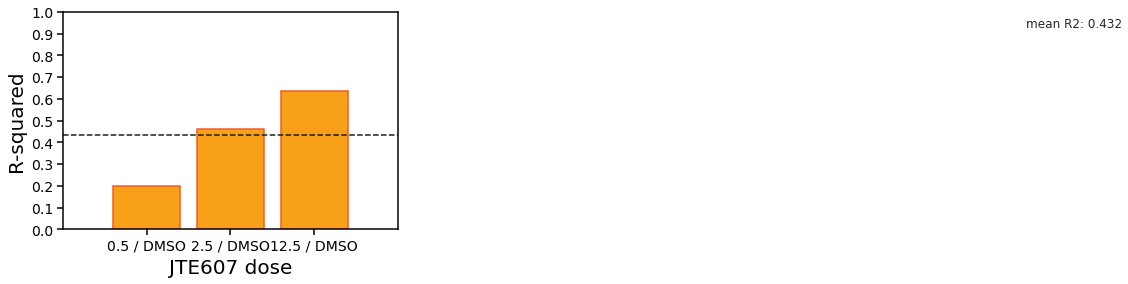

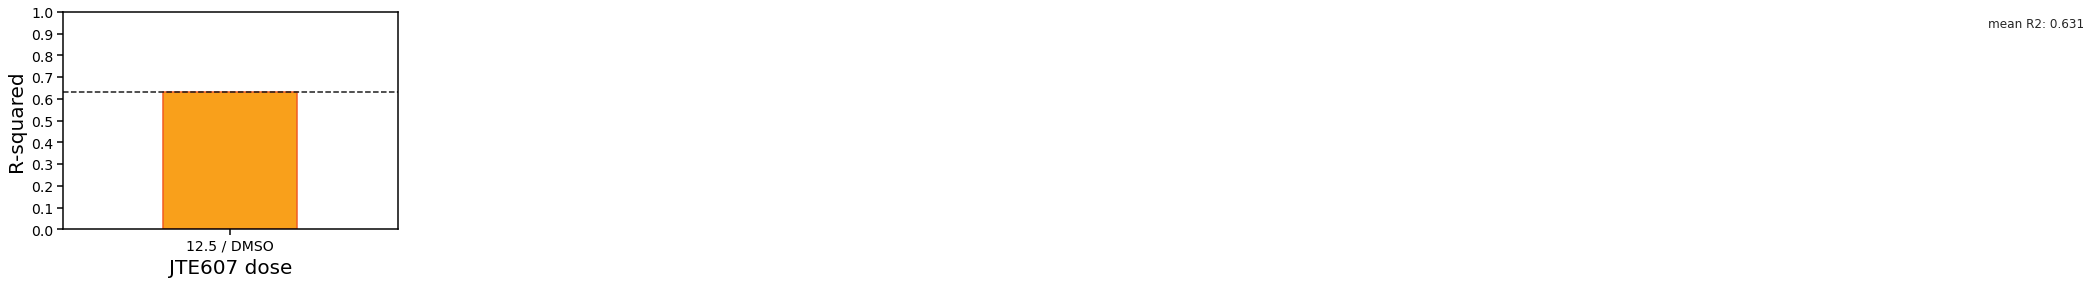

In [6]:
# going forward with merged_PAS_ratio, taking top 4120/2, 6 epochs, Trial 1

trial_num = 1

"""
Train model. 
TODO: look up "Using the hyperparameter-optimised values."
"""
model = weighted_poly_profile_model_mask(seq_e_train, res_train, res_weight, nb_epoch=6,border_mode='same',
                   inp_len=input_len, nodes=80, layers=3, nbr_filters=120, filter_len=8, dropout1=0,
                   dropout2=0,dropout3=0.1)

predictions = model.predict(seq_e_test)
print(predictions)
scores = []
print("predictions: ", predictions[:,0])
print("test: ", res_test[res_test.columns[0]])
for i in range(3):
    pred = predictions[:,i]
    obs = res_test[res_test.columns[i]]
    slope, intercept, r_value, p_value, std_err = stats.linregress(obs,pred)
    scores.append(round(r_value**2, 3))
mean = round(np.array(scores).sum() / len(scores),3)
f, ax = plt.subplots()
ax.bar(x=["0.5 / DMSO", "2.5 / DMSO", "12.5 / DMSO"],height=scores,align='center',color='#F9A01B',edgecolor='#F15A22', linewidth=1.5)
ax.set_xticks(range(0,3));
ax.set_xlim((-1,3))

ax.set_yticks(np.arange(0,1.01,0.1))
ax.set_yticklabels([round(x,1) for x in np.arange(0,1.01,0.1)])
ax.axhline(mean, linewidth=1.5, ls='dashed', color='k')
ax.text(x=10.5, y=0.93, s='mean R2: ' + str(mean))
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xlabel('JTE607 dose', size=20)
ax.set_ylabel('R-squared', size=20);

print("scores", scores)

model.save("%s/JTE607_CNN_25nt_6epoch_4col_model_%s.hdf5" % (output_models_dir, trial_num))


"""
Train model using only 0 and 12.5
TODO: look up "Using the hyperparameter-optimised values."
"""
print(res_train.columns)
two_columns_train = res_train.drop(['0p5uM_percent', '2p5uM_percent'], 1)
#two_columns_train = two_columns_train.div(two_columns_train.sum(axis=1), axis=0)

model = weighted_poly_profile_model_mask(seq_e_train, two_columns_train, res_weight, nb_epoch=6,border_mode='same',
                   inp_len=input_len, nodes=80, layers=3, nbr_filters=120, filter_len=8, dropout1=0,
                   dropout2=0,dropout3=0.1)

two_columns_test = res_test.drop(['0p5uM_percent', '2p5uM_percent'], 1)
#two_columns_test = two_columns_test.div(two_columns_test.sum(axis=1), axis=0)

predictions = model.predict(seq_e_test)
print(predictions)
scores = []
print("predictions: ", predictions[:,0])
print("test: ", two_columns_test[two_columns_test.columns[0]])
for i in range(1):
    pred = predictions[:,i]
    obs = two_columns_test[two_columns_test.columns[i]]
    slope, intercept, r_value, p_value, std_err = stats.linregress(obs,pred)
    scores.append(round(r_value**2, 3))
mean = round(np.array(scores).sum() / len(scores),3)
f, ax = plt.subplots()
ax.bar(x=["12.5 / DMSO"],height=scores,align='center',color='#F9A01B',edgecolor='#F15A22', linewidth=1.5)
ax.set_xticks(range(0,1));
ax.set_xlim((-1,1))

ax.set_yticks(np.arange(0,1.01,0.1))
ax.set_yticklabels([round(x,1) for x in np.arange(0,1.01,0.1)])
ax.axhline(mean, linewidth=1.5, ls='dashed', color='k')
ax.text(x=10.5, y=0.93, s='mean R2: ' + str(mean))
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xlabel('JTE607 dose', size=20)
ax.set_ylabel('R-squared', size=20);

print("scores", scores)

model.save("%s/JTE607_CNN_25nt_6epoch_2col_model_%s.hdf5" % (output_models_dir, trial_num))


Epoch 1/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.1300
Epoch 2/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0824
Epoch 3/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0807
Epoch 4/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0795
Epoch 5/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0783
Epoch 6/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0769
[[ 0.02832532  0.13628887  0.2657203 ]
 [ 0.01613489 -0.25693175 -0.6128294 ]
 [ 0.17826462  0.202633    0.25581503]
 ...
 [ 0.14999339  0.28013596  0.46223998]
 [ 0.01228539 -0.08676284 -0.2655527 ]
 [ 0.03040394  0.0165219   0.04421135]]
predictions:  [0.02832532 0.01613489 0.17826462 ... 0.14999339 0.01228539 0.03040394]
test:  0       0.158997
1      -0.011128
2       0.262036
3       0.398708
4       0.235647
          ...   
2055    0.328462
2056    0.125522
2057    0.150214
2058    0.197842
2059 

/home/ec2-user/anaconda3/envs/tensorflow2_p37/lib/python3.7/site-packages/ipykernel/__main__.py:48: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


Epoch 1/6
1578/1578 [==============================] - 7s 5ms/step - loss: 0.1808
Epoch 2/6
1578/1578 [==============================] - 7s 5ms/step - loss: 0.1005
Epoch 3/6
1578/1578 [==============================] - 7s 5ms/step - loss: 0.0965
Epoch 4/6
1578/1578 [==============================] - 7s 5ms/step - loss: 0.0944
Epoch 5/6
1578/1578 [==============================] - 7s 5ms/step - loss: 0.0928
Epoch 6/6
1578/1578 [==============================] - 7s 5ms/step - loss: 0.0899
[[ 0.23544544]
 [-0.6442257 ]
 [ 0.239243  ]
 ...
 [ 0.39241543]
 [-0.30392554]
 [ 0.21417418]]
predictions:  [ 0.23544544 -0.6442257   0.239243   ...  0.39241543 -0.30392554
  0.21417418]
test:  0       0.382862
1      -0.694788
2       0.345407
3       0.725449
4       0.653545
          ...   
2055    0.545658
2056    0.333900
2057    0.255428
2058   -0.479392
2059    0.064910
Name: 12p5uM_percent, Length: 2060, dtype: float64


/home/ec2-user/anaconda3/envs/tensorflow2_p37/lib/python3.7/site-packages/ipykernel/__main__.py:55: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


scores [0.628]


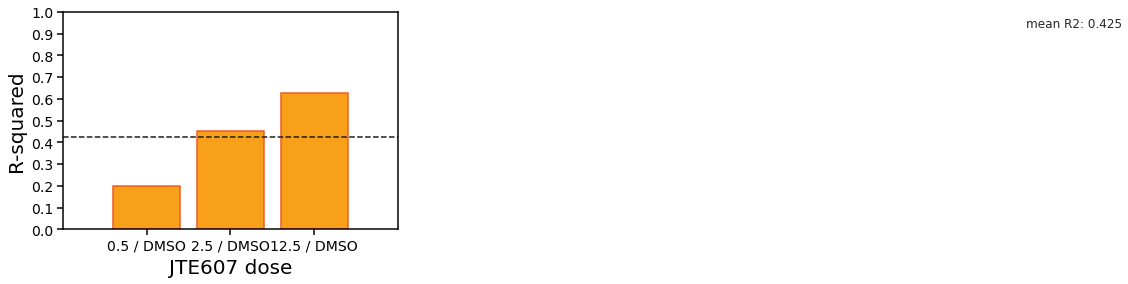

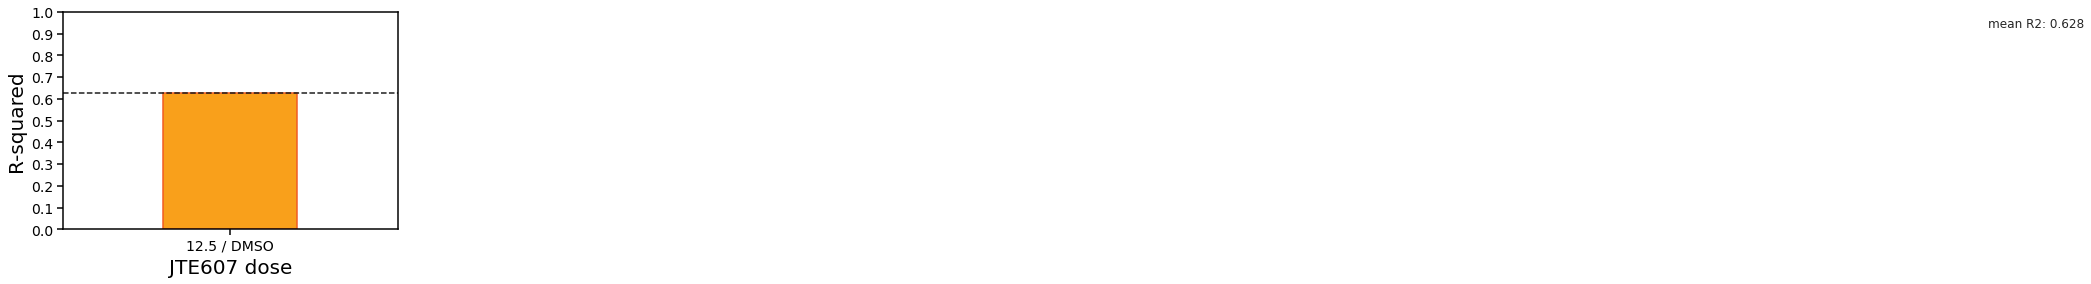

In [7]:
# going forward with merged_PAS_ratio, taking top 4120/2, 6 epochs, Trial 2

trial_num = 2

"""
Train model. 
TODO: look up "Using the hyperparameter-optimised values."
"""
model = weighted_poly_profile_model_mask(seq_e_train, res_train, res_weight, nb_epoch=6,border_mode='same',
                   inp_len=input_len, nodes=80, layers=3, nbr_filters=120, filter_len=8, dropout1=0,
                   dropout2=0,dropout3=0.1)

predictions = model.predict(seq_e_test)
print(predictions)
scores = []
print("predictions: ", predictions[:,0])
print("test: ", res_test[res_test.columns[0]])
for i in range(3):
    pred = predictions[:,i]
    obs = res_test[res_test.columns[i]]
    slope, intercept, r_value, p_value, std_err = stats.linregress(obs,pred)
    scores.append(round(r_value**2, 3))
mean = round(np.array(scores).sum() / len(scores),3)
f, ax = plt.subplots()
ax.bar(x=["0.5 / DMSO", "2.5 / DMSO", "12.5 / DMSO"],height=scores,align='center',color='#F9A01B',edgecolor='#F15A22', linewidth=1.5)
ax.set_xticks(range(0,3));
ax.set_xlim((-1,3))

ax.set_yticks(np.arange(0,1.01,0.1))
ax.set_yticklabels([round(x,1) for x in np.arange(0,1.01,0.1)])
ax.axhline(mean, linewidth=1.5, ls='dashed', color='k')
ax.text(x=10.5, y=0.93, s='mean R2: ' + str(mean))
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xlabel('JTE607 dose', size=20)
ax.set_ylabel('R-squared', size=20);

print("scores", scores)

model.save("%s/JTE607_CNN_25nt_6epoch_4col_model_%s.hdf5" % (output_models_dir, trial_num))


"""
Train model using only 0 and 12.5
TODO: look up "Using the hyperparameter-optimised values."
"""
print(res_train.columns)
two_columns_train = res_train.drop(['0p5uM_percent', '2p5uM_percent'], 1)
#two_columns_train = two_columns_train.div(two_columns_train.sum(axis=1), axis=0)

model = weighted_poly_profile_model_mask(seq_e_train, two_columns_train, res_weight, nb_epoch=6,border_mode='same',
                   inp_len=input_len, nodes=80, layers=3, nbr_filters=120, filter_len=8, dropout1=0,
                   dropout2=0,dropout3=0.1)

two_columns_test = res_test.drop(['0p5uM_percent', '2p5uM_percent'], 1)
#two_columns_test = two_columns_test.div(two_columns_test.sum(axis=1), axis=0)

predictions = model.predict(seq_e_test)
print(predictions)
scores = []
print("predictions: ", predictions[:,0])
print("test: ", two_columns_test[two_columns_test.columns[0]])
for i in range(1):
    pred = predictions[:,i]
    obs = two_columns_test[two_columns_test.columns[i]]
    slope, intercept, r_value, p_value, std_err = stats.linregress(obs,pred)
    scores.append(round(r_value**2, 3))
mean = round(np.array(scores).sum() / len(scores),3)
f, ax = plt.subplots()
ax.bar(x=["12.5 / DMSO"],height=scores,align='center',color='#F9A01B',edgecolor='#F15A22', linewidth=1.5)
ax.set_xticks(range(0,1));
ax.set_xlim((-1,1))

ax.set_yticks(np.arange(0,1.01,0.1))
ax.set_yticklabels([round(x,1) for x in np.arange(0,1.01,0.1)])
ax.axhline(mean, linewidth=1.5, ls='dashed', color='k')
ax.text(x=10.5, y=0.93, s='mean R2: ' + str(mean))
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xlabel('JTE607 dose', size=20)
ax.set_ylabel('R-squared', size=20);

print("scores", scores)

model.save("%s/JTE607_CNN_25nt_6epoch_2col_model_%s.hdf5" % (output_models_dir, trial_num))


Epoch 1/6
1578/1578 [==============================] - 7s 5ms/step - loss: 0.1481
Epoch 2/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0839
Epoch 3/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0808
Epoch 4/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0796
Epoch 5/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0786
Epoch 6/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0770
[[ 0.06077034  0.13602279  0.25243407]
 [-0.03127201 -0.28156358 -0.79224503]
 [ 0.12499958  0.17419076  0.26537275]
 ...
 [ 0.04632034  0.14261866  0.24976392]
 [-0.0618343  -0.2340377  -0.43287194]
 [ 0.04517911  0.05655706  0.08795471]]
predictions:  [ 0.06077034 -0.03127201  0.12499958 ...  0.04632034 -0.0618343
  0.04517911]
test:  0       0.158997
1      -0.011128
2       0.262036
3       0.398708
4       0.235647
          ...   
2055    0.328462
2056    0.125522
2057    0.150214
2058    0.197842

/home/ec2-user/anaconda3/envs/tensorflow2_p37/lib/python3.7/site-packages/ipykernel/__main__.py:48: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


Epoch 1/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.1715
Epoch 2/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.1000
Epoch 3/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0966
Epoch 4/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0948
Epoch 5/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0925
Epoch 6/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0899
[[ 0.1790758 ]
 [-0.63699114]
 [ 0.26843613]
 ...
 [ 0.14850414]
 [-0.42856598]
 [ 0.16610599]]
predictions:  [ 0.1790758  -0.63699114  0.26843613 ...  0.14850414 -0.42856598
  0.16610599]
test:  0       0.382862
1      -0.694788
2       0.345407
3       0.725449
4       0.653545
          ...   
2055    0.545658
2056    0.333900
2057    0.255428
2058   -0.479392
2059    0.064910
Name: 12p5uM_percent, Length: 2060, dtype: float64


/home/ec2-user/anaconda3/envs/tensorflow2_p37/lib/python3.7/site-packages/ipykernel/__main__.py:55: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


scores [0.615]


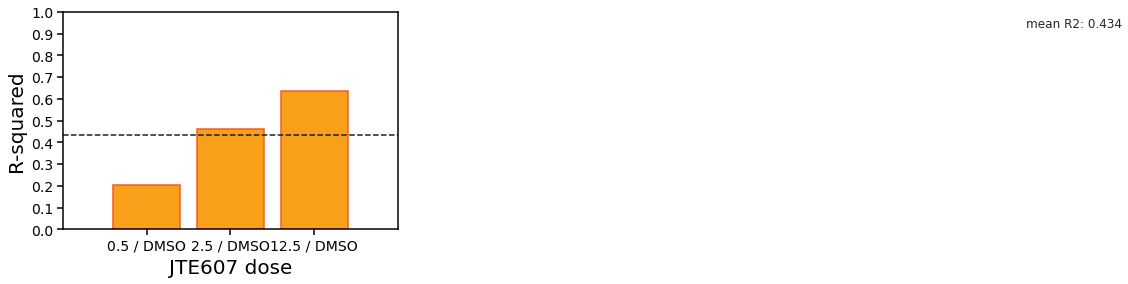

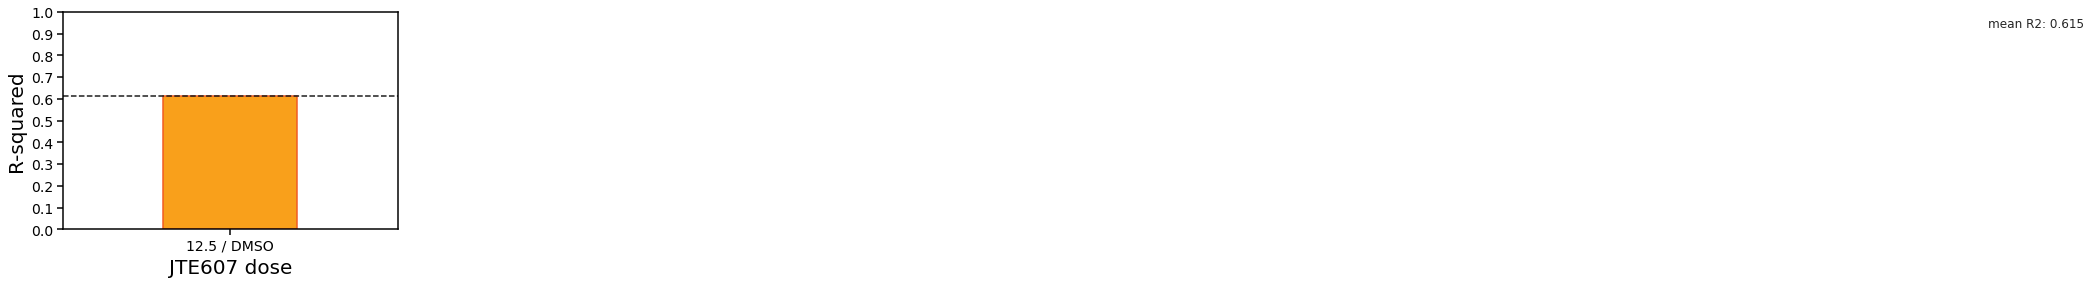

In [8]:
# going forward with merged_PAS_ratio, taking top 4120/2, 6 epochs, Trial 3

trial_num = 3

"""
Train model. 
TODO: look up "Using the hyperparameter-optimised values."
"""
model = weighted_poly_profile_model_mask(seq_e_train, res_train, res_weight, nb_epoch=6,border_mode='same',
                   inp_len=input_len, nodes=80, layers=3, nbr_filters=120, filter_len=8, dropout1=0,
                   dropout2=0,dropout3=0.1)

predictions = model.predict(seq_e_test)
print(predictions)
scores = []
print("predictions: ", predictions[:,0])
print("test: ", res_test[res_test.columns[0]])
for i in range(3):
    pred = predictions[:,i]
    obs = res_test[res_test.columns[i]]
    slope, intercept, r_value, p_value, std_err = stats.linregress(obs,pred)
    scores.append(round(r_value**2, 3))
mean = round(np.array(scores).sum() / len(scores),3)
f, ax = plt.subplots()
ax.bar(x=["0.5 / DMSO", "2.5 / DMSO", "12.5 / DMSO"],height=scores,align='center',color='#F9A01B',edgecolor='#F15A22', linewidth=1.5)
ax.set_xticks(range(0,3));
ax.set_xlim((-1,3))

ax.set_yticks(np.arange(0,1.01,0.1))
ax.set_yticklabels([round(x,1) for x in np.arange(0,1.01,0.1)])
ax.axhline(mean, linewidth=1.5, ls='dashed', color='k')
ax.text(x=10.5, y=0.93, s='mean R2: ' + str(mean))
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xlabel('JTE607 dose', size=20)
ax.set_ylabel('R-squared', size=20);

print("scores", scores)

model.save("%s/JTE607_CNN_25nt_6epoch_4col_model_%s.hdf5" % (output_models_dir, trial_num))


"""
Train model using only 0 and 12.5
TODO: look up "Using the hyperparameter-optimised values."
"""
print(res_train.columns)
two_columns_train = res_train.drop(['0p5uM_percent', '2p5uM_percent'], 1)
#two_columns_train = two_columns_train.div(two_columns_train.sum(axis=1), axis=0)

model = weighted_poly_profile_model_mask(seq_e_train, two_columns_train, res_weight, nb_epoch=6,border_mode='same',
                   inp_len=input_len, nodes=80, layers=3, nbr_filters=120, filter_len=8, dropout1=0,
                   dropout2=0,dropout3=0.1)

two_columns_test = res_test.drop(['0p5uM_percent', '2p5uM_percent'], 1)
#two_columns_test = two_columns_test.div(two_columns_test.sum(axis=1), axis=0)

predictions = model.predict(seq_e_test)
print(predictions)
scores = []
print("predictions: ", predictions[:,0])
print("test: ", two_columns_test[two_columns_test.columns[0]])
for i in range(1):
    pred = predictions[:,i]
    obs = two_columns_test[two_columns_test.columns[i]]
    slope, intercept, r_value, p_value, std_err = stats.linregress(obs,pred)
    scores.append(round(r_value**2, 3))
mean = round(np.array(scores).sum() / len(scores),3)
f, ax = plt.subplots()
ax.bar(x=["12.5 / DMSO"],height=scores,align='center',color='#F9A01B',edgecolor='#F15A22', linewidth=1.5)
ax.set_xticks(range(0,1));
ax.set_xlim((-1,1))

ax.set_yticks(np.arange(0,1.01,0.1))
ax.set_yticklabels([round(x,1) for x in np.arange(0,1.01,0.1)])
ax.axhline(mean, linewidth=1.5, ls='dashed', color='k')
ax.text(x=10.5, y=0.93, s='mean R2: ' + str(mean))
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xlabel('JTE607 dose', size=20)
ax.set_ylabel('R-squared', size=20);

print("scores", scores)

model.save("%s/JTE607_CNN_25nt_6epoch_2col_model_%s.hdf5" % (output_models_dir, trial_num))


Epoch 1/6
1578/1578 [==============================] - 7s 5ms/step - loss: 0.1462
Epoch 2/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0836
Epoch 3/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0808
Epoch 4/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0795
Epoch 5/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0787
Epoch 6/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0772
[[ 0.02053137  0.11915249  0.25123033]
 [-0.10148645 -0.3714403  -0.8796118 ]
 [ 0.09654906  0.18401806  0.26263463]
 ...
 [ 0.09153225  0.22355336  0.38432428]
 [-0.08686344 -0.28548393 -0.5731933 ]
 [ 0.0734398   0.12288319  0.17101428]]
predictions:  [ 0.02053137 -0.10148645  0.09654906 ...  0.09153225 -0.08686344
  0.0734398 ]
test:  0       0.158997
1      -0.011128
2       0.262036
3       0.398708
4       0.235647
          ...   
2055    0.328462
2056    0.125522
2057    0.150214
2058    0.19784

/home/ec2-user/anaconda3/envs/tensorflow2_p37/lib/python3.7/site-packages/ipykernel/__main__.py:48: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


Epoch 1/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.1640
Epoch 2/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0998
Epoch 3/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0963
Epoch 4/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0944
Epoch 5/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0925
Epoch 6/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0900
[[ 0.28471094]
 [-0.43533635]
 [ 0.22229823]
 ...
 [ 0.39876416]
 [-0.32376978]
 [ 0.11615614]]
predictions:  [ 0.28471094 -0.43533635  0.22229823 ...  0.39876416 -0.32376978
  0.11615614]
test:  0       0.382862
1      -0.694788
2       0.345407
3       0.725449
4       0.653545
          ...   
2055    0.545658
2056    0.333900
2057    0.255428
2058   -0.479392
2059    0.064910
Name: 12p5uM_percent, Length: 2060, dtype: float64


/home/ec2-user/anaconda3/envs/tensorflow2_p37/lib/python3.7/site-packages/ipykernel/__main__.py:55: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


scores [0.624]


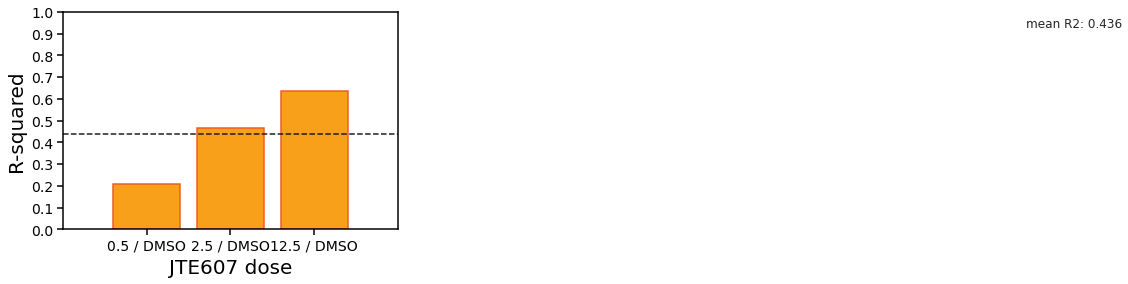

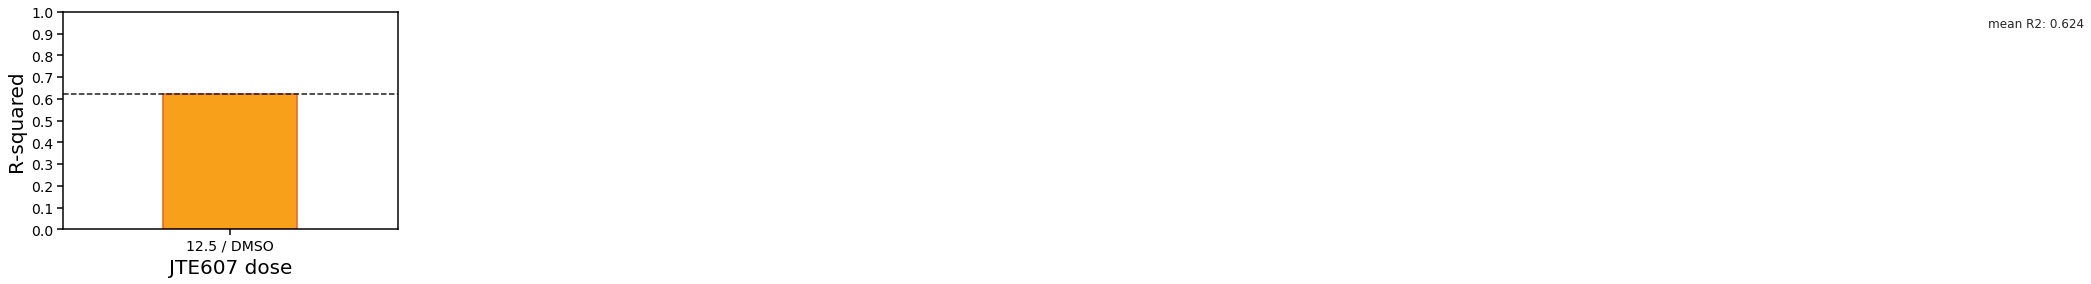

In [9]:
# going forward with merged_PAS_ratio, taking top 4120/2, 6 epochs, Trial 4

trial_num = 4

"""
Train model. 
TODO: look up "Using the hyperparameter-optimised values."
"""
model = weighted_poly_profile_model_mask(seq_e_train, res_train, res_weight, nb_epoch=6,border_mode='same',
                   inp_len=input_len, nodes=80, layers=3, nbr_filters=120, filter_len=8, dropout1=0,
                   dropout2=0,dropout3=0.1)

predictions = model.predict(seq_e_test)
print(predictions)
scores = []
print("predictions: ", predictions[:,0])
print("test: ", res_test[res_test.columns[0]])
for i in range(3):
    pred = predictions[:,i]
    obs = res_test[res_test.columns[i]]
    slope, intercept, r_value, p_value, std_err = stats.linregress(obs,pred)
    scores.append(round(r_value**2, 3))
mean = round(np.array(scores).sum() / len(scores),3)
f, ax = plt.subplots()
ax.bar(x=["0.5 / DMSO", "2.5 / DMSO", "12.5 / DMSO"],height=scores,align='center',color='#F9A01B',edgecolor='#F15A22', linewidth=1.5)
ax.set_xticks(range(0,3));
ax.set_xlim((-1,3))

ax.set_yticks(np.arange(0,1.01,0.1))
ax.set_yticklabels([round(x,1) for x in np.arange(0,1.01,0.1)])
ax.axhline(mean, linewidth=1.5, ls='dashed', color='k')
ax.text(x=10.5, y=0.93, s='mean R2: ' + str(mean))
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xlabel('JTE607 dose', size=20)
ax.set_ylabel('R-squared', size=20);

print("scores", scores)

model.save("%s/JTE607_CNN_25nt_6epoch_4col_model_%s.hdf5" % (output_models_dir, trial_num))


"""
Train model using only 0 and 12.5
TODO: look up "Using the hyperparameter-optimised values."
"""
print(res_train.columns)
two_columns_train = res_train.drop(['0p5uM_percent', '2p5uM_percent'], 1)
#two_columns_train = two_columns_train.div(two_columns_train.sum(axis=1), axis=0)

model = weighted_poly_profile_model_mask(seq_e_train, two_columns_train, res_weight, nb_epoch=6,border_mode='same',
                   inp_len=input_len, nodes=80, layers=3, nbr_filters=120, filter_len=8, dropout1=0,
                   dropout2=0,dropout3=0.1)

two_columns_test = res_test.drop(['0p5uM_percent', '2p5uM_percent'], 1)
#two_columns_test = two_columns_test.div(two_columns_test.sum(axis=1), axis=0)

predictions = model.predict(seq_e_test)
print(predictions)
scores = []
print("predictions: ", predictions[:,0])
print("test: ", two_columns_test[two_columns_test.columns[0]])
for i in range(1):
    pred = predictions[:,i]
    obs = two_columns_test[two_columns_test.columns[i]]
    slope, intercept, r_value, p_value, std_err = stats.linregress(obs,pred)
    scores.append(round(r_value**2, 3))
mean = round(np.array(scores).sum() / len(scores),3)
f, ax = plt.subplots()
ax.bar(x=["12.5 / DMSO"],height=scores,align='center',color='#F9A01B',edgecolor='#F15A22', linewidth=1.5)
ax.set_xticks(range(0,1));
ax.set_xlim((-1,1))

ax.set_yticks(np.arange(0,1.01,0.1))
ax.set_yticklabels([round(x,1) for x in np.arange(0,1.01,0.1)])
ax.axhline(mean, linewidth=1.5, ls='dashed', color='k')
ax.text(x=10.5, y=0.93, s='mean R2: ' + str(mean))
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xlabel('JTE607 dose', size=20)
ax.set_ylabel('R-squared', size=20);

print("scores", scores)

model.save("%s/JTE607_CNN_25nt_6epoch_2col_model_%s.hdf5" % (output_models_dir, trial_num))


Epoch 1/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.1297
Epoch 2/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0825
Epoch 3/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0806
Epoch 4/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0794
Epoch 5/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0783
Epoch 6/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0768
[[ 0.09226027  0.18519168  0.27106094]
 [ 0.05269818 -0.13567309 -0.50388455]
 [ 0.21488948  0.28305906  0.41533425]
 ...
 [ 0.16792612  0.29572445  0.45847672]
 [-0.06386683 -0.21881372 -0.5647067 ]
 [ 0.10373558  0.13200705  0.25095308]]
predictions:  [ 0.09226027  0.05269818  0.21488948 ...  0.16792612 -0.06386683
  0.10373558]
test:  0       0.158997
1      -0.011128
2       0.262036
3       0.398708
4       0.235647
          ...   
2055    0.328462
2056    0.125522
2057    0.150214
2058    0.19784

/home/ec2-user/anaconda3/envs/tensorflow2_p37/lib/python3.7/site-packages/ipykernel/__main__.py:48: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


Epoch 1/6
1578/1578 [==============================] - 7s 5ms/step - loss: 0.1580
Epoch 2/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0989
Epoch 3/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0964
Epoch 4/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0941
Epoch 5/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0921
Epoch 6/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0898
[[ 0.27431512]
 [-0.44772655]
 [ 0.3286571 ]
 ...
 [ 0.332578  ]
 [-0.26550496]
 [ 0.2684245 ]]
predictions:  [ 0.27431512 -0.44772655  0.3286571  ...  0.332578   -0.26550496
  0.2684245 ]
test:  0       0.382862
1      -0.694788
2       0.345407
3       0.725449
4       0.653545
          ...   
2055    0.545658
2056    0.333900
2057    0.255428
2058   -0.479392
2059    0.064910
Name: 12p5uM_percent, Length: 2060, dtype: float64


/home/ec2-user/anaconda3/envs/tensorflow2_p37/lib/python3.7/site-packages/ipykernel/__main__.py:55: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


scores [0.624]


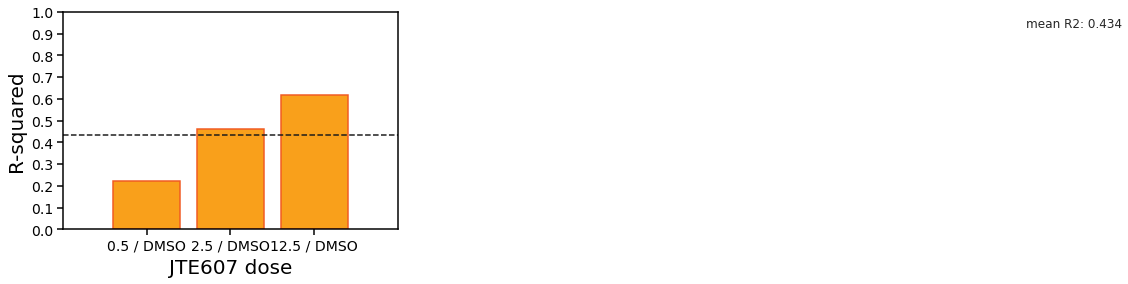

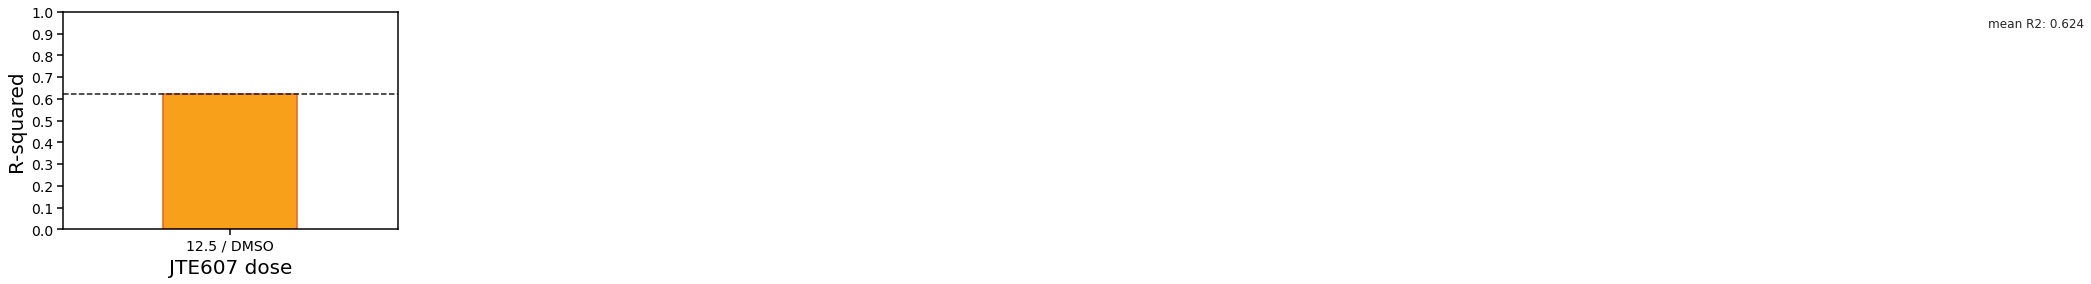

In [10]:
# going forward with merged_PAS_ratio, taking top 4120/2, 6 epochs, Trial 5

trial_num = 5

"""
Train model. 
TODO: look up "Using the hyperparameter-optimised values."
"""
model = weighted_poly_profile_model_mask(seq_e_train, res_train, res_weight, nb_epoch=6,border_mode='same',
                   inp_len=input_len, nodes=80, layers=3, nbr_filters=120, filter_len=8, dropout1=0,
                   dropout2=0,dropout3=0.1)

predictions = model.predict(seq_e_test)
print(predictions)
scores = []
print("predictions: ", predictions[:,0])
print("test: ", res_test[res_test.columns[0]])
for i in range(3):
    pred = predictions[:,i]
    obs = res_test[res_test.columns[i]]
    slope, intercept, r_value, p_value, std_err = stats.linregress(obs,pred)
    scores.append(round(r_value**2, 3))
mean = round(np.array(scores).sum() / len(scores),3)
f, ax = plt.subplots()
ax.bar(x=["0.5 / DMSO", "2.5 / DMSO", "12.5 / DMSO"],height=scores,align='center',color='#F9A01B',edgecolor='#F15A22', linewidth=1.5)
ax.set_xticks(range(0,3));
ax.set_xlim((-1,3))

ax.set_yticks(np.arange(0,1.01,0.1))
ax.set_yticklabels([round(x,1) for x in np.arange(0,1.01,0.1)])
ax.axhline(mean, linewidth=1.5, ls='dashed', color='k')
ax.text(x=10.5, y=0.93, s='mean R2: ' + str(mean))
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xlabel('JTE607 dose', size=20)
ax.set_ylabel('R-squared', size=20);

print("scores", scores)

model.save("%s/JTE607_CNN_25nt_6epoch_4col_model_%s.hdf5" % (output_models_dir, trial_num))


"""
Train model using only 0 and 12.5
TODO: look up "Using the hyperparameter-optimised values."
"""
print(res_train.columns)
two_columns_train = res_train.drop(['0p5uM_percent', '2p5uM_percent'], 1)
#two_columns_train = two_columns_train.div(two_columns_train.sum(axis=1), axis=0)

model = weighted_poly_profile_model_mask(seq_e_train, two_columns_train, res_weight, nb_epoch=6,border_mode='same',
                   inp_len=input_len, nodes=80, layers=3, nbr_filters=120, filter_len=8, dropout1=0,
                   dropout2=0,dropout3=0.1)

two_columns_test = res_test.drop(['0p5uM_percent', '2p5uM_percent'], 1)
#two_columns_test = two_columns_test.div(two_columns_test.sum(axis=1), axis=0)

predictions = model.predict(seq_e_test)
print(predictions)
scores = []
print("predictions: ", predictions[:,0])
print("test: ", two_columns_test[two_columns_test.columns[0]])
for i in range(1):
    pred = predictions[:,i]
    obs = two_columns_test[two_columns_test.columns[i]]
    slope, intercept, r_value, p_value, std_err = stats.linregress(obs,pred)
    scores.append(round(r_value**2, 3))
mean = round(np.array(scores).sum() / len(scores),3)
f, ax = plt.subplots()
ax.bar(x=["12.5 / DMSO"],height=scores,align='center',color='#F9A01B',edgecolor='#F15A22', linewidth=1.5)
ax.set_xticks(range(0,1));
ax.set_xlim((-1,1))

ax.set_yticks(np.arange(0,1.01,0.1))
ax.set_yticklabels([round(x,1) for x in np.arange(0,1.01,0.1)])
ax.axhline(mean, linewidth=1.5, ls='dashed', color='k')
ax.text(x=10.5, y=0.93, s='mean R2: ' + str(mean))
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xlabel('JTE607 dose', size=20)
ax.set_ylabel('R-squared', size=20);

print("scores", scores)

model.save("%s/JTE607_CNN_25nt_6epoch_2col_model_%s.hdf5" % (output_models_dir, trial_num))


Epoch 1/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.1251
Epoch 2/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0828
Epoch 3/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0806
Epoch 4/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0796
Epoch 5/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0782
Epoch 6/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0768
[[ 0.0752433   0.13944933  0.24204388]
 [ 0.02949724 -0.21197939 -0.63972497]
 [ 0.10729504  0.17720085  0.21812102]
 ...
 [ 0.14058566  0.22935897  0.3604882 ]
 [-0.09250106 -0.27894133 -0.6437109 ]
 [ 0.08185753  0.13348228  0.2012501 ]]
predictions:  [ 0.0752433   0.02949724  0.10729504 ...  0.14058566 -0.09250106
  0.08185753]
test:  0       0.158997
1      -0.011128
2       0.262036
3       0.398708
4       0.235647
          ...   
2055    0.328462
2056    0.125522
2057    0.150214
2058    0.19784

/home/ec2-user/anaconda3/envs/tensorflow2_p37/lib/python3.7/site-packages/ipykernel/__main__.py:48: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


Epoch 1/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.1651
Epoch 2/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.1001
Epoch 3/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0964
Epoch 4/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0944
Epoch 5/6
1578/1578 [==============================] - 7s 5ms/step - loss: 0.0924
Epoch 6/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0897
[[ 0.17860404]
 [-0.37891358]
 [ 0.30652913]
 ...
 [ 0.35957724]
 [-0.5270722 ]
 [ 0.2845487 ]]
predictions:  [ 0.17860404 -0.37891358  0.30652913 ...  0.35957724 -0.5270722
  0.2845487 ]
test:  0       0.382862
1      -0.694788
2       0.345407
3       0.725449
4       0.653545
          ...   
2055    0.545658
2056    0.333900
2057    0.255428
2058   -0.479392
2059    0.064910
Name: 12p5uM_percent, Length: 2060, dtype: float64


/home/ec2-user/anaconda3/envs/tensorflow2_p37/lib/python3.7/site-packages/ipykernel/__main__.py:55: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


scores [0.621]


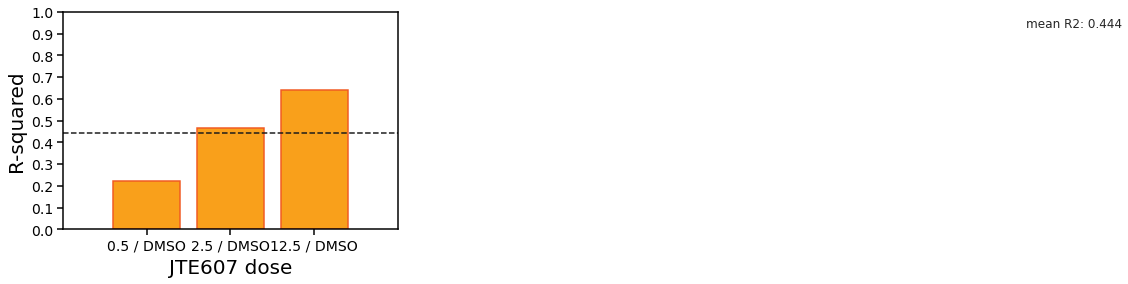

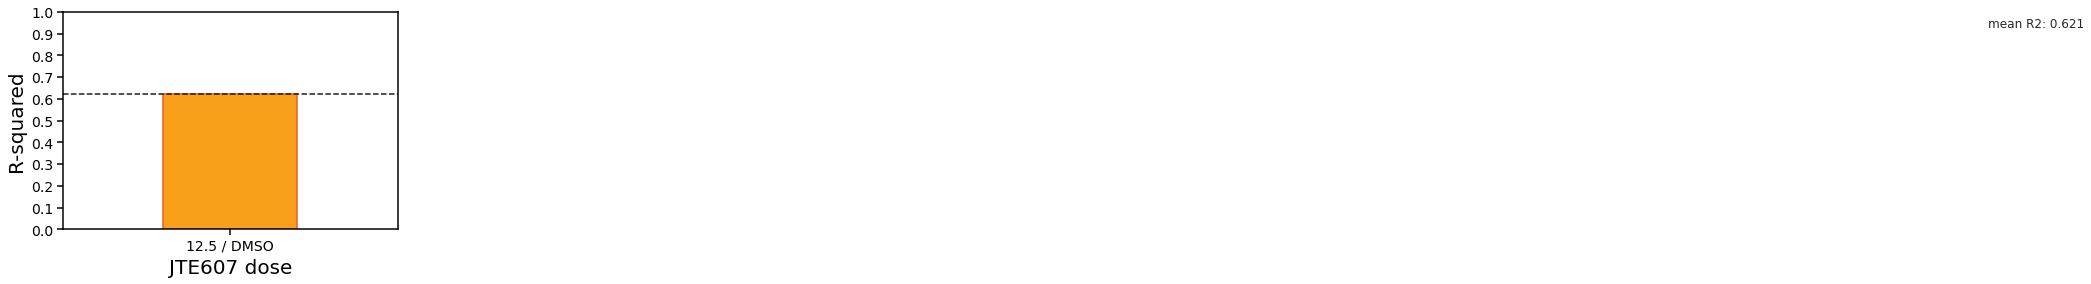

In [11]:
# going forward with merged_PAS_ratio, taking top 4120/2, 6 epochs, Trial 6

trial_num = 6

"""
Train model. 
TODO: look up "Using the hyperparameter-optimised values."
"""
model = weighted_poly_profile_model_mask(seq_e_train, res_train, res_weight, nb_epoch=6,border_mode='same',
                   inp_len=input_len, nodes=80, layers=3, nbr_filters=120, filter_len=8, dropout1=0,
                   dropout2=0,dropout3=0.1)

predictions = model.predict(seq_e_test)
print(predictions)
scores = []
print("predictions: ", predictions[:,0])
print("test: ", res_test[res_test.columns[0]])
for i in range(3):
    pred = predictions[:,i]
    obs = res_test[res_test.columns[i]]
    slope, intercept, r_value, p_value, std_err = stats.linregress(obs,pred)
    scores.append(round(r_value**2, 3))
mean = round(np.array(scores).sum() / len(scores),3)
f, ax = plt.subplots()
ax.bar(x=["0.5 / DMSO", "2.5 / DMSO", "12.5 / DMSO"],height=scores,align='center',color='#F9A01B',edgecolor='#F15A22', linewidth=1.5)
ax.set_xticks(range(0,3));
ax.set_xlim((-1,3))

ax.set_yticks(np.arange(0,1.01,0.1))
ax.set_yticklabels([round(x,1) for x in np.arange(0,1.01,0.1)])
ax.axhline(mean, linewidth=1.5, ls='dashed', color='k')
ax.text(x=10.5, y=0.93, s='mean R2: ' + str(mean))
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xlabel('JTE607 dose', size=20)
ax.set_ylabel('R-squared', size=20);

print("scores", scores)

model.save("%s/JTE607_CNN_25nt_6epoch_4col_model_%s.hdf5" % (output_models_dir, trial_num))


"""
Train model using only 0 and 12.5
TODO: look up "Using the hyperparameter-optimised values."
"""
print(res_train.columns)
two_columns_train = res_train.drop(['0p5uM_percent', '2p5uM_percent'], 1)
#two_columns_train = two_columns_train.div(two_columns_train.sum(axis=1), axis=0)

model = weighted_poly_profile_model_mask(seq_e_train, two_columns_train, res_weight, nb_epoch=6,border_mode='same',
                   inp_len=input_len, nodes=80, layers=3, nbr_filters=120, filter_len=8, dropout1=0,
                   dropout2=0,dropout3=0.1)

two_columns_test = res_test.drop(['0p5uM_percent', '2p5uM_percent'], 1)
#two_columns_test = two_columns_test.div(two_columns_test.sum(axis=1), axis=0)

predictions = model.predict(seq_e_test)
print(predictions)
scores = []
print("predictions: ", predictions[:,0])
print("test: ", two_columns_test[two_columns_test.columns[0]])
for i in range(1):
    pred = predictions[:,i]
    obs = two_columns_test[two_columns_test.columns[i]]
    slope, intercept, r_value, p_value, std_err = stats.linregress(obs,pred)
    scores.append(round(r_value**2, 3))
mean = round(np.array(scores).sum() / len(scores),3)
f, ax = plt.subplots()
ax.bar(x=["12.5 / DMSO"],height=scores,align='center',color='#F9A01B',edgecolor='#F15A22', linewidth=1.5)
ax.set_xticks(range(0,1));
ax.set_xlim((-1,1))

ax.set_yticks(np.arange(0,1.01,0.1))
ax.set_yticklabels([round(x,1) for x in np.arange(0,1.01,0.1)])
ax.axhline(mean, linewidth=1.5, ls='dashed', color='k')
ax.text(x=10.5, y=0.93, s='mean R2: ' + str(mean))
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xlabel('JTE607 dose', size=20)
ax.set_ylabel('R-squared', size=20);

print("scores", scores)

model.save("%s/JTE607_CNN_25nt_6epoch_2col_model_%s.hdf5" % (output_models_dir, trial_num))


Epoch 1/6
1578/1578 [==============================] - 7s 5ms/step - loss: 0.1459
Epoch 2/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0841
Epoch 3/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0809
Epoch 4/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0796
Epoch 5/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0784
Epoch 6/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0771
[[ 0.04283356  0.10130195  0.16237897]
 [ 0.05355458 -0.12188863 -0.5433218 ]
 [ 0.09060661  0.19331576  0.2836926 ]
 ...
 [ 0.11160396  0.24258928  0.43401045]
 [-0.0183487  -0.15440999 -0.38362664]
 [ 0.06365724  0.15361252  0.20495516]]
predictions:  [ 0.04283356  0.05355458  0.09060661 ...  0.11160396 -0.0183487
  0.06365724]
test:  0       0.158997
1      -0.011128
2       0.262036
3       0.398708
4       0.235647
          ...   
2055    0.328462
2056    0.125522
2057    0.150214
2058    0.197842

/home/ec2-user/anaconda3/envs/tensorflow2_p37/lib/python3.7/site-packages/ipykernel/__main__.py:48: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


Epoch 1/6
1578/1578 [==============================] - 7s 5ms/step - loss: 0.1708
Epoch 2/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0997
Epoch 3/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0968
Epoch 4/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0948
Epoch 5/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0926
Epoch 6/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0900
[[ 0.24585654]
 [-0.72127706]
 [ 0.3446048 ]
 ...
 [ 0.48473507]
 [-0.5533534 ]
 [ 0.20285799]]
predictions:  [ 0.24585654 -0.72127706  0.3446048  ...  0.48473507 -0.5533534
  0.20285799]
test:  0       0.382862
1      -0.694788
2       0.345407
3       0.725449
4       0.653545
          ...   
2055    0.545658
2056    0.333900
2057    0.255428
2058   -0.479392
2059    0.064910
Name: 12p5uM_percent, Length: 2060, dtype: float64

/home/ec2-user/anaconda3/envs/tensorflow2_p37/lib/python3.7/site-packages/ipykernel/__main__.py:55: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



scores [0.639]


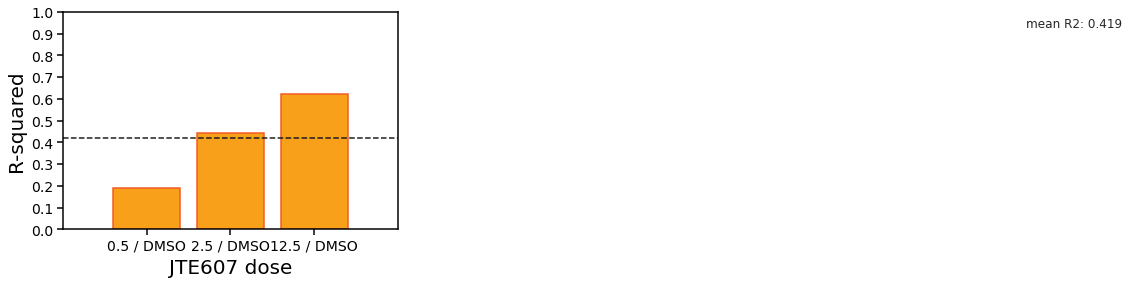

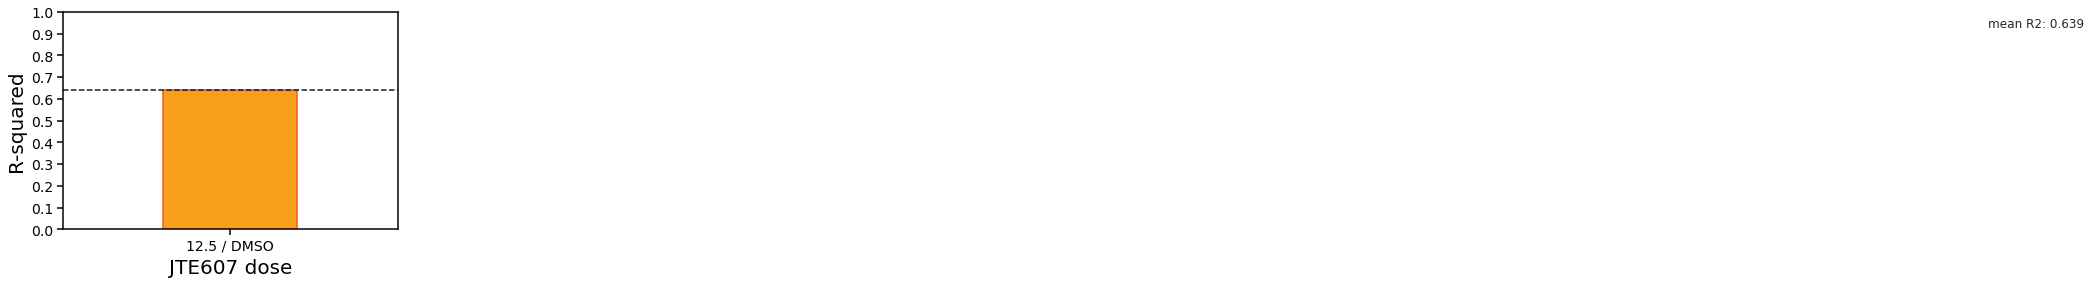

In [12]:
# going forward with merged_PAS_ratio, taking top 4120/2, 6 epochs, Trial 7

trial_num = 7

"""
Train model. 
TODO: look up "Using the hyperparameter-optimised values."
"""
model = weighted_poly_profile_model_mask(seq_e_train, res_train, res_weight, nb_epoch=6,border_mode='same',
                   inp_len=input_len, nodes=80, layers=3, nbr_filters=120, filter_len=8, dropout1=0,
                   dropout2=0,dropout3=0.1)

predictions = model.predict(seq_e_test)
print(predictions)
scores = []
print("predictions: ", predictions[:,0])
print("test: ", res_test[res_test.columns[0]])
for i in range(3):
    pred = predictions[:,i]
    obs = res_test[res_test.columns[i]]
    slope, intercept, r_value, p_value, std_err = stats.linregress(obs,pred)
    scores.append(round(r_value**2, 3))
mean = round(np.array(scores).sum() / len(scores),3)
f, ax = plt.subplots()
ax.bar(x=["0.5 / DMSO", "2.5 / DMSO", "12.5 / DMSO"],height=scores,align='center',color='#F9A01B',edgecolor='#F15A22', linewidth=1.5)
ax.set_xticks(range(0,3));
ax.set_xlim((-1,3))

ax.set_yticks(np.arange(0,1.01,0.1))
ax.set_yticklabels([round(x,1) for x in np.arange(0,1.01,0.1)])
ax.axhline(mean, linewidth=1.5, ls='dashed', color='k')
ax.text(x=10.5, y=0.93, s='mean R2: ' + str(mean))
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xlabel('JTE607 dose', size=20)
ax.set_ylabel('R-squared', size=20);

print("scores", scores)

model.save("%s/JTE607_CNN_25nt_6epoch_4col_model_%s.hdf5" % (output_models_dir, trial_num))


"""
Train model using only 0 and 12.5
TODO: look up "Using the hyperparameter-optimised values."
"""
print(res_train.columns)
two_columns_train = res_train.drop(['0p5uM_percent', '2p5uM_percent'], 1)
#two_columns_train = two_columns_train.div(two_columns_train.sum(axis=1), axis=0)

model = weighted_poly_profile_model_mask(seq_e_train, two_columns_train, res_weight, nb_epoch=6,border_mode='same',
                   inp_len=input_len, nodes=80, layers=3, nbr_filters=120, filter_len=8, dropout1=0,
                   dropout2=0,dropout3=0.1)

two_columns_test = res_test.drop(['0p5uM_percent', '2p5uM_percent'], 1)
#two_columns_test = two_columns_test.div(two_columns_test.sum(axis=1), axis=0)

predictions = model.predict(seq_e_test)
print(predictions)
scores = []
print("predictions: ", predictions[:,0])
print("test: ", two_columns_test[two_columns_test.columns[0]])
for i in range(1):
    pred = predictions[:,i]
    obs = two_columns_test[two_columns_test.columns[i]]
    slope, intercept, r_value, p_value, std_err = stats.linregress(obs,pred)
    scores.append(round(r_value**2, 3))
mean = round(np.array(scores).sum() / len(scores),3)
f, ax = plt.subplots()
ax.bar(x=["12.5 / DMSO"],height=scores,align='center',color='#F9A01B',edgecolor='#F15A22', linewidth=1.5)
ax.set_xticks(range(0,1));
ax.set_xlim((-1,1))

ax.set_yticks(np.arange(0,1.01,0.1))
ax.set_yticklabels([round(x,1) for x in np.arange(0,1.01,0.1)])
ax.axhline(mean, linewidth=1.5, ls='dashed', color='k')
ax.text(x=10.5, y=0.93, s='mean R2: ' + str(mean))
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xlabel('JTE607 dose', size=20)
ax.set_ylabel('R-squared', size=20);

print("scores", scores)

model.save("%s/JTE607_CNN_25nt_6epoch_2col_model_%s.hdf5" % (output_models_dir, trial_num))


Epoch 1/6
1578/1578 [==============================] - 7s 5ms/step - loss: 0.1389
Epoch 2/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0842
Epoch 3/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0810
Epoch 4/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0797
Epoch 5/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0784
Epoch 6/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0772
[[-0.00382622  0.0627688   0.11347417]
 [-0.04789117 -0.2353052  -0.55842364]
 [ 0.04525427  0.12198947  0.14761221]
 ...
 [ 0.16610867  0.30879474  0.4187264 ]
 [-0.07488981 -0.17010804 -0.34298322]
 [ 0.10750031  0.11465152  0.15233347]]
predictions:  [-0.00382622 -0.04789117  0.04525427 ...  0.16610867 -0.07488981
  0.10750031]
test:  0       0.158997
1      -0.011128
2       0.262036
3       0.398708
4       0.235647
          ...   
2055    0.328462
2056    0.125522
2057    0.150214
2058    0.19784

/home/ec2-user/anaconda3/envs/tensorflow2_p37/lib/python3.7/site-packages/ipykernel/__main__.py:48: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


Epoch 1/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.1564
Epoch 2/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0992
Epoch 3/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0963
Epoch 4/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0942
Epoch 5/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0923
Epoch 6/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0897
[[ 0.23680125]
 [-0.5322069 ]
 [ 0.17692758]
 ...
 [ 0.24209608]
 [-0.29555714]
 [ 0.06963055]]
predictions:  [ 0.23680125 -0.5322069   0.17692758 ...  0.24209608 -0.29555714
  0.06963055]
test:  0       0.382862
1      -0.694788
2       0.345407
3       0.725449
4       0.653545
          ...   
2055    0.545658
2056    0.333900
2057    0.255428
2058   -0.479392
2059    0.064910
Name: 12p5uM_percent, Length: 2060, dtype: float64


/home/ec2-user/anaconda3/envs/tensorflow2_p37/lib/python3.7/site-packages/ipykernel/__main__.py:55: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


scores [0.62]


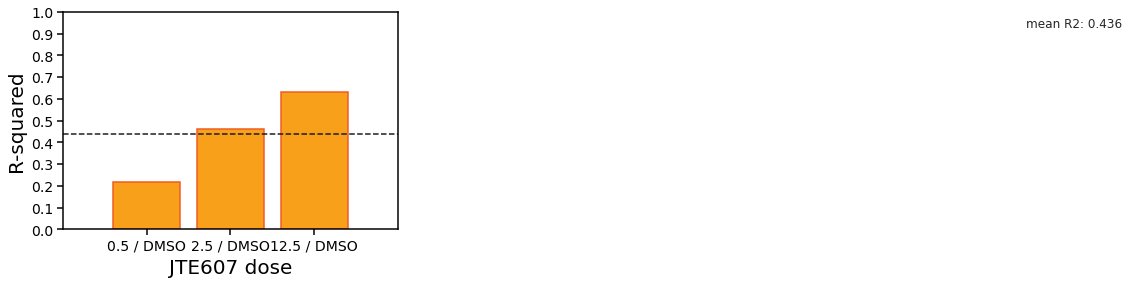

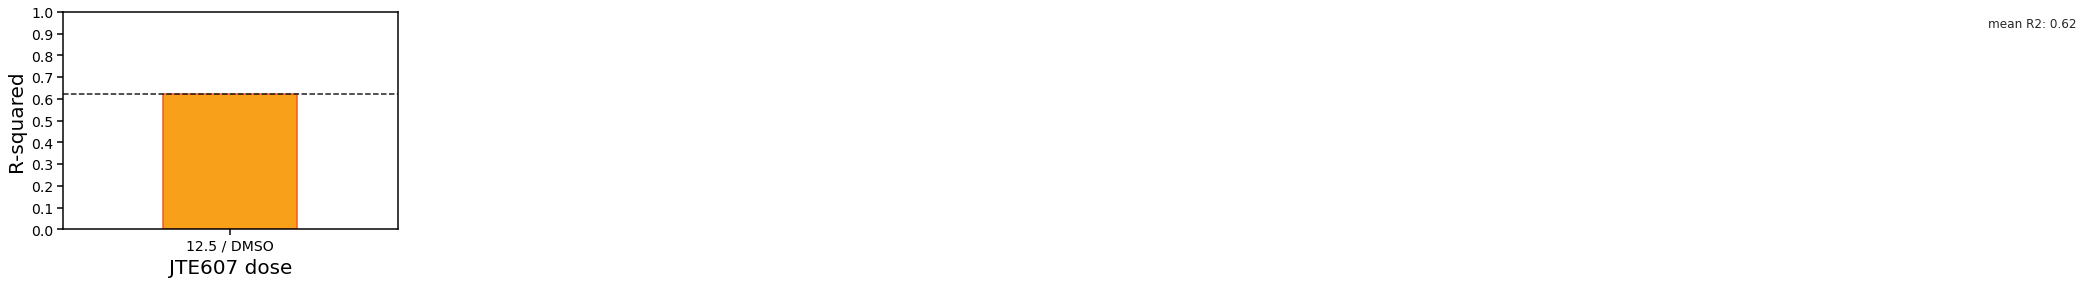

In [13]:
# going forward with merged_PAS_ratio, taking top 4120/2, 6 epochs, Trial 8

trial_num = 8

"""
Train model. 
TODO: look up "Using the hyperparameter-optimised values."
"""
model = weighted_poly_profile_model_mask(seq_e_train, res_train, res_weight, nb_epoch=6,border_mode='same',
                   inp_len=input_len, nodes=80, layers=3, nbr_filters=120, filter_len=8, dropout1=0,
                   dropout2=0,dropout3=0.1)

predictions = model.predict(seq_e_test)
print(predictions)
scores = []
print("predictions: ", predictions[:,0])
print("test: ", res_test[res_test.columns[0]])
for i in range(3):
    pred = predictions[:,i]
    obs = res_test[res_test.columns[i]]
    slope, intercept, r_value, p_value, std_err = stats.linregress(obs,pred)
    scores.append(round(r_value**2, 3))
mean = round(np.array(scores).sum() / len(scores),3)
f, ax = plt.subplots()
ax.bar(x=["0.5 / DMSO", "2.5 / DMSO", "12.5 / DMSO"],height=scores,align='center',color='#F9A01B',edgecolor='#F15A22', linewidth=1.5)
ax.set_xticks(range(0,3));
ax.set_xlim((-1,3))

ax.set_yticks(np.arange(0,1.01,0.1))
ax.set_yticklabels([round(x,1) for x in np.arange(0,1.01,0.1)])
ax.axhline(mean, linewidth=1.5, ls='dashed', color='k')
ax.text(x=10.5, y=0.93, s='mean R2: ' + str(mean))
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xlabel('JTE607 dose', size=20)
ax.set_ylabel('R-squared', size=20);

print("scores", scores)

model.save("%s/JTE607_CNN_25nt_6epoch_4col_model_%s.hdf5" % (output_models_dir, trial_num))


"""
Train model using only 0 and 12.5
TODO: look up "Using the hyperparameter-optimised values."
"""
print(res_train.columns)
two_columns_train = res_train.drop(['0p5uM_percent', '2p5uM_percent'], 1)
#two_columns_train = two_columns_train.div(two_columns_train.sum(axis=1), axis=0)

model = weighted_poly_profile_model_mask(seq_e_train, two_columns_train, res_weight, nb_epoch=6,border_mode='same',
                   inp_len=input_len, nodes=80, layers=3, nbr_filters=120, filter_len=8, dropout1=0,
                   dropout2=0,dropout3=0.1)

two_columns_test = res_test.drop(['0p5uM_percent', '2p5uM_percent'], 1)
#two_columns_test = two_columns_test.div(two_columns_test.sum(axis=1), axis=0)

predictions = model.predict(seq_e_test)
print(predictions)
scores = []
print("predictions: ", predictions[:,0])
print("test: ", two_columns_test[two_columns_test.columns[0]])
for i in range(1):
    pred = predictions[:,i]
    obs = two_columns_test[two_columns_test.columns[i]]
    slope, intercept, r_value, p_value, std_err = stats.linregress(obs,pred)
    scores.append(round(r_value**2, 3))
mean = round(np.array(scores).sum() / len(scores),3)
f, ax = plt.subplots()
ax.bar(x=["12.5 / DMSO"],height=scores,align='center',color='#F9A01B',edgecolor='#F15A22', linewidth=1.5)
ax.set_xticks(range(0,1));
ax.set_xlim((-1,1))

ax.set_yticks(np.arange(0,1.01,0.1))
ax.set_yticklabels([round(x,1) for x in np.arange(0,1.01,0.1)])
ax.axhline(mean, linewidth=1.5, ls='dashed', color='k')
ax.text(x=10.5, y=0.93, s='mean R2: ' + str(mean))
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xlabel('JTE607 dose', size=20)
ax.set_ylabel('R-squared', size=20);

print("scores", scores)

model.save("%s/JTE607_CNN_25nt_6epoch_2col_model_%s.hdf5" % (output_models_dir, trial_num))


Epoch 1/6
1578/1578 [==============================] - 7s 5ms/step - loss: 0.1367
Epoch 2/6
1578/1578 [==============================] - 7s 5ms/step - loss: 0.0833
Epoch 3/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0807
Epoch 4/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0794
Epoch 5/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0782
Epoch 6/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0771
[[ 0.00571335  0.08580596  0.21948446]
 [-0.0477259  -0.27843323 -0.6064607 ]
 [ 0.1407238   0.22202772  0.25063235]
 ...
 [ 0.06429298  0.20680544  0.27103555]
 [-0.06123618 -0.19125423 -0.49038416]
 [ 0.08514443  0.15691778  0.2571761 ]]
predictions:  [ 0.00571335 -0.0477259   0.1407238  ...  0.06429298 -0.06123618
  0.08514443]
test:  0       0.158997
1      -0.011128
2       0.262036
3       0.398708
4       0.235647
          ...   
2055    0.328462
2056    0.125522
2057    0.150214
2058    0.19784

/home/ec2-user/anaconda3/envs/tensorflow2_p37/lib/python3.7/site-packages/ipykernel/__main__.py:48: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


Epoch 1/6
1578/1578 [==============================] - 7s 5ms/step - loss: 0.1622
Epoch 2/6
1578/1578 [==============================] - 7s 5ms/step - loss: 0.0996
Epoch 3/6
1578/1578 [==============================] - 7s 5ms/step - loss: 0.0965
Epoch 4/6
1578/1578 [==============================] - 7s 5ms/step - loss: 0.0945
Epoch 5/6
1578/1578 [==============================] - 7s 5ms/step - loss: 0.0926
Epoch 6/6
1578/1578 [==============================] - 7s 5ms/step - loss: 0.0895
[[ 0.35548   ]
 [-0.32607803]
 [ 0.176586  ]
 ...
 [ 0.3689048 ]
 [-0.20002115]
 [ 0.19996712]]
predictions:  [ 0.35548    -0.32607803  0.176586   ...  0.3689048  -0.20002115
  0.19996712]
test:  0       0.382862
1      -0.694788
2       0.345407
3       0.725449
4       0.653545
          ...   
2055    0.545658
2056    0.333900
2057    0.255428
2058   -0.479392
2059    0.064910
Name: 12p5uM_percent, Length: 2060, dtype: float64


/home/ec2-user/anaconda3/envs/tensorflow2_p37/lib/python3.7/site-packages/ipykernel/__main__.py:55: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


scores [0.606]


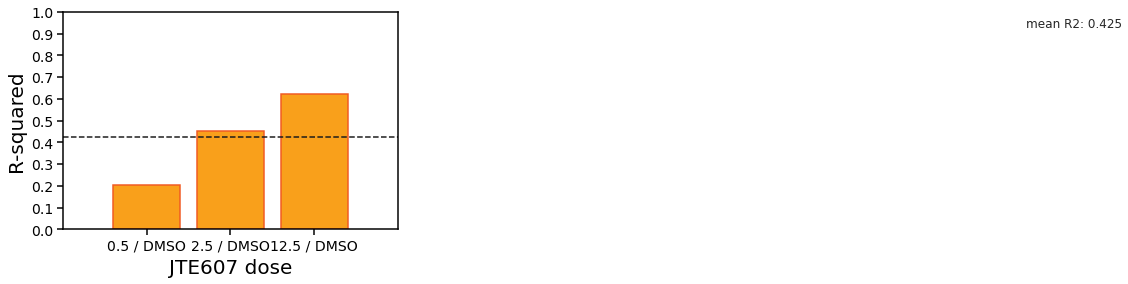

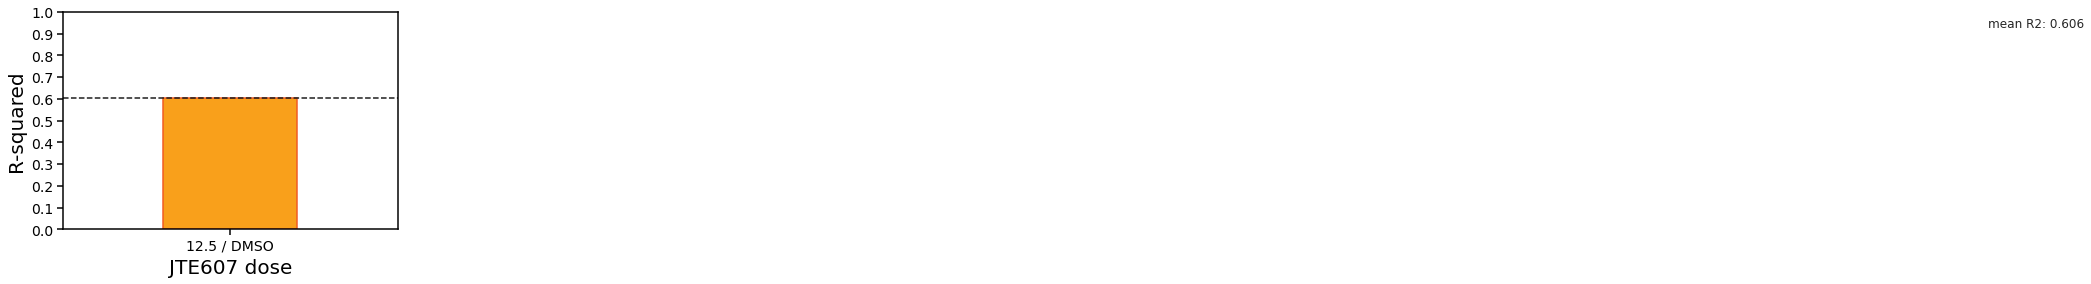

In [14]:
# going forward with merged_PAS_ratio, taking top 4120/2, 6 epochs, Trial 9

trial_num = 9

"""
Train model. 
TODO: look up "Using the hyperparameter-optimised values."
"""
model = weighted_poly_profile_model_mask(seq_e_train, res_train, res_weight, nb_epoch=6,border_mode='same',
                   inp_len=input_len, nodes=80, layers=3, nbr_filters=120, filter_len=8, dropout1=0,
                   dropout2=0,dropout3=0.1)

predictions = model.predict(seq_e_test)
print(predictions)
scores = []
print("predictions: ", predictions[:,0])
print("test: ", res_test[res_test.columns[0]])
for i in range(3):
    pred = predictions[:,i]
    obs = res_test[res_test.columns[i]]
    slope, intercept, r_value, p_value, std_err = stats.linregress(obs,pred)
    scores.append(round(r_value**2, 3))
mean = round(np.array(scores).sum() / len(scores),3)
f, ax = plt.subplots()
ax.bar(x=["0.5 / DMSO", "2.5 / DMSO", "12.5 / DMSO"],height=scores,align='center',color='#F9A01B',edgecolor='#F15A22', linewidth=1.5)
ax.set_xticks(range(0,3));
ax.set_xlim((-1,3))

ax.set_yticks(np.arange(0,1.01,0.1))
ax.set_yticklabels([round(x,1) for x in np.arange(0,1.01,0.1)])
ax.axhline(mean, linewidth=1.5, ls='dashed', color='k')
ax.text(x=10.5, y=0.93, s='mean R2: ' + str(mean))
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xlabel('JTE607 dose', size=20)
ax.set_ylabel('R-squared', size=20);

print("scores", scores)

model.save("%s/JTE607_CNN_25nt_6epoch_4col_model_%s.hdf5" % (output_models_dir, trial_num))


"""
Train model using only 0 and 12.5
TODO: look up "Using the hyperparameter-optimised values."
"""
print(res_train.columns)
two_columns_train = res_train.drop(['0p5uM_percent', '2p5uM_percent'], 1)
#two_columns_train = two_columns_train.div(two_columns_train.sum(axis=1), axis=0)

model = weighted_poly_profile_model_mask(seq_e_train, two_columns_train, res_weight, nb_epoch=6,border_mode='same',
                   inp_len=input_len, nodes=80, layers=3, nbr_filters=120, filter_len=8, dropout1=0,
                   dropout2=0,dropout3=0.1)

two_columns_test = res_test.drop(['0p5uM_percent', '2p5uM_percent'], 1)
#two_columns_test = two_columns_test.div(two_columns_test.sum(axis=1), axis=0)

predictions = model.predict(seq_e_test)
print(predictions)
scores = []
print("predictions: ", predictions[:,0])
print("test: ", two_columns_test[two_columns_test.columns[0]])
for i in range(1):
    pred = predictions[:,i]
    obs = two_columns_test[two_columns_test.columns[i]]
    slope, intercept, r_value, p_value, std_err = stats.linregress(obs,pred)
    scores.append(round(r_value**2, 3))
mean = round(np.array(scores).sum() / len(scores),3)
f, ax = plt.subplots()
ax.bar(x=["12.5 / DMSO"],height=scores,align='center',color='#F9A01B',edgecolor='#F15A22', linewidth=1.5)
ax.set_xticks(range(0,1));
ax.set_xlim((-1,1))

ax.set_yticks(np.arange(0,1.01,0.1))
ax.set_yticklabels([round(x,1) for x in np.arange(0,1.01,0.1)])
ax.axhline(mean, linewidth=1.5, ls='dashed', color='k')
ax.text(x=10.5, y=0.93, s='mean R2: ' + str(mean))
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xlabel('JTE607 dose', size=20)
ax.set_ylabel('R-squared', size=20);

print("scores", scores)

model.save("%s/JTE607_CNN_25nt_6epoch_2col_model_%s.hdf5" % (output_models_dir, trial_num))


Epoch 1/6
1578/1578 [==============================] - 7s 5ms/step - loss: 0.1336
Epoch 2/6
1578/1578 [==============================] - 7s 5ms/step - loss: 0.0831
Epoch 3/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0810
Epoch 4/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0796
Epoch 5/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0784
Epoch 6/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0771
[[ 0.10395497  0.17401093  0.2748018 ]
 [ 0.01834384 -0.16114639 -0.46037522]
 [ 0.15720394  0.20012654  0.25722432]
 ...
 [ 0.2585191   0.3997828   0.54923165]
 [-0.0781263  -0.20194127 -0.41559693]
 [ 0.1107775   0.14239697  0.22770846]]
predictions:  [ 0.10395497  0.01834384  0.15720394 ...  0.2585191  -0.0781263
  0.1107775 ]
test:  0       0.158997
1      -0.011128
2       0.262036
3       0.398708
4       0.235647
          ...   
2055    0.328462
2056    0.125522
2057    0.150214
2058    0.197842

/home/ec2-user/anaconda3/envs/tensorflow2_p37/lib/python3.7/site-packages/ipykernel/__main__.py:48: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


Epoch 1/6
1578/1578 [==============================] - 7s 5ms/step - loss: 0.1513
Epoch 2/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.1001
Epoch 3/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0971
Epoch 4/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0942
Epoch 5/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0916
Epoch 6/6
1578/1578 [==============================] - 7s 4ms/step - loss: 0.0893
[[ 0.17347062]
 [-0.5633883 ]
 [ 0.25116947]
 ...
 [ 0.36910495]
 [-0.5150617 ]
 [ 0.21036276]]
predictions:  [ 0.17347062 -0.5633883   0.25116947 ...  0.36910495 -0.5150617
  0.21036276]
test:  0       0.382862
1      -0.694788
2       0.345407
3       0.725449
4       0.653545
          ...   
2055    0.545658
2056    0.333900
2057    0.255428
2058   -0.479392
2059    0.064910
Name: 12p5uM_percent, Length: 2060, dtype: float64


/home/ec2-user/anaconda3/envs/tensorflow2_p37/lib/python3.7/site-packages/ipykernel/__main__.py:55: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


scores [0.632]


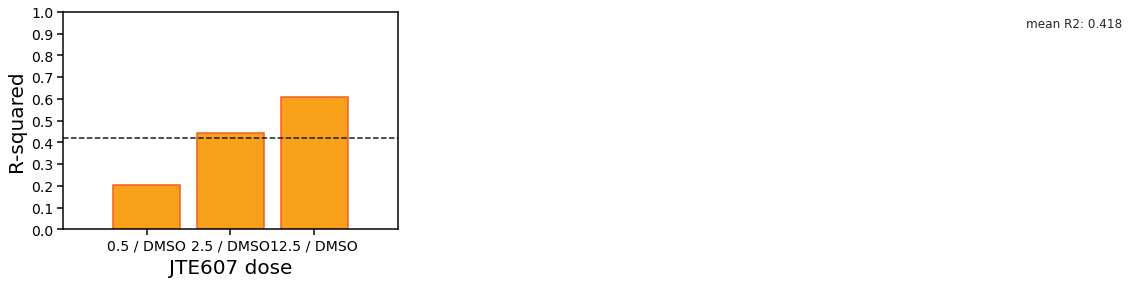

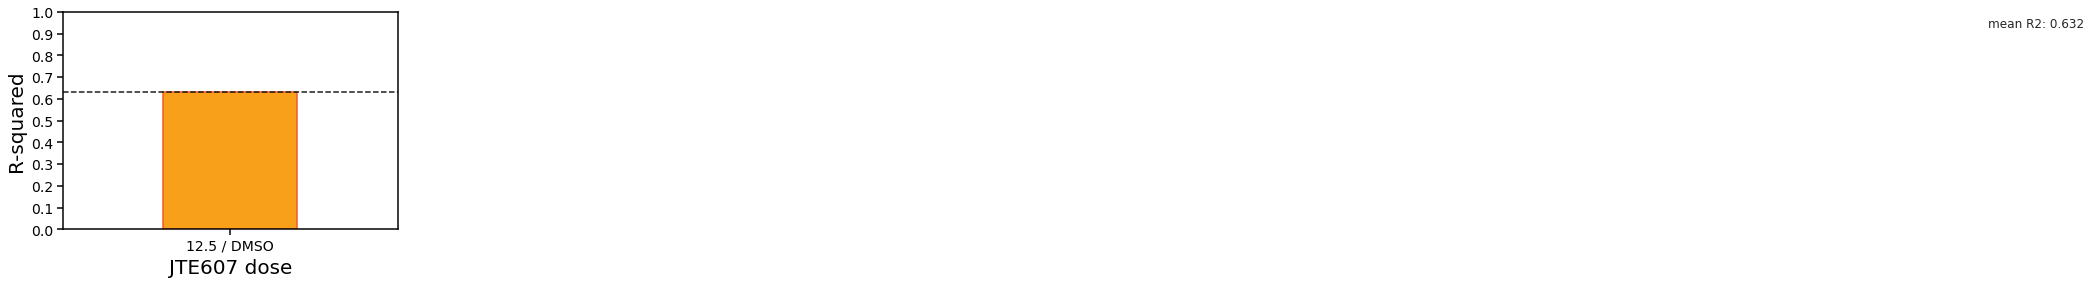

In [15]:
# going forward with merged_PAS_ratio, taking top 4120/2, 6 epochs, Trial 10

trial_num = 10

"""
Train model. 
TODO: look up "Using the hyperparameter-optimised values."
"""
model = weighted_poly_profile_model_mask(seq_e_train, res_train, res_weight, nb_epoch=6,border_mode='same',
                   inp_len=input_len, nodes=80, layers=3, nbr_filters=120, filter_len=8, dropout1=0,
                   dropout2=0,dropout3=0.1)

predictions = model.predict(seq_e_test)
print(predictions)
scores = []
print("predictions: ", predictions[:,0])
print("test: ", res_test[res_test.columns[0]])
for i in range(3):
    pred = predictions[:,i]
    obs = res_test[res_test.columns[i]]
    slope, intercept, r_value, p_value, std_err = stats.linregress(obs,pred)
    scores.append(round(r_value**2, 3))
mean = round(np.array(scores).sum() / len(scores),3)
f, ax = plt.subplots()
ax.bar(x=["0.5 / DMSO", "2.5 / DMSO", "12.5 / DMSO"],height=scores,align='center',color='#F9A01B',edgecolor='#F15A22', linewidth=1.5)
ax.set_xticks(range(0,3));
ax.set_xlim((-1,3))

ax.set_yticks(np.arange(0,1.01,0.1))
ax.set_yticklabels([round(x,1) for x in np.arange(0,1.01,0.1)])
ax.axhline(mean, linewidth=1.5, ls='dashed', color='k')
ax.text(x=10.5, y=0.93, s='mean R2: ' + str(mean))
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xlabel('JTE607 dose', size=20)
ax.set_ylabel('R-squared', size=20);

print("scores", scores)

model.save("%s/JTE607_CNN_25nt_6epoch_4col_model_%s.hdf5" % (output_models_dir, trial_num))


"""
Train model using only 0 and 12.5
TODO: look up "Using the hyperparameter-optimised values."
"""
print(res_train.columns)
two_columns_train = res_train.drop(['0p5uM_percent', '2p5uM_percent'], 1)
#two_columns_train = two_columns_train.div(two_columns_train.sum(axis=1), axis=0)

model = weighted_poly_profile_model_mask(seq_e_train, two_columns_train, res_weight, nb_epoch=6,border_mode='same',
                   inp_len=input_len, nodes=80, layers=3, nbr_filters=120, filter_len=8, dropout1=0,
                   dropout2=0,dropout3=0.1)

two_columns_test = res_test.drop(['0p5uM_percent', '2p5uM_percent'], 1)
#two_columns_test = two_columns_test.div(two_columns_test.sum(axis=1), axis=0)

predictions = model.predict(seq_e_test)
print(predictions)
scores = []
print("predictions: ", predictions[:,0])
print("test: ", two_columns_test[two_columns_test.columns[0]])
for i in range(1):
    pred = predictions[:,i]
    obs = two_columns_test[two_columns_test.columns[i]]
    slope, intercept, r_value, p_value, std_err = stats.linregress(obs,pred)
    scores.append(round(r_value**2, 3))
mean = round(np.array(scores).sum() / len(scores),3)
f, ax = plt.subplots()
ax.bar(x=["12.5 / DMSO"],height=scores,align='center',color='#F9A01B',edgecolor='#F15A22', linewidth=1.5)
ax.set_xticks(range(0,1));
ax.set_xlim((-1,1))

ax.set_yticks(np.arange(0,1.01,0.1))
ax.set_yticklabels([round(x,1) for x in np.arange(0,1.01,0.1)])
ax.axhline(mean, linewidth=1.5, ls='dashed', color='k')
ax.text(x=10.5, y=0.93, s='mean R2: ' + str(mean))
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xlabel('JTE607 dose', size=20)
ax.set_ylabel('R-squared', size=20);

print("scores", scores)

model.save("%s/JTE607_CNN_25nt_6epoch_2col_model_%s.hdf5" % (output_models_dir, trial_num))


In [16]:
#run on test sets 
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import spearmanr, linregress

def relevant_metrics(y_pred, y_true):
    #returns the metrics for the dataframe to save for model performance 
    #sklearn r2 is not the linear coefficent 
    #using the scpy linregress function to get that r2
    res = linregress(y_pred, y_true)
    return mean_squared_error(y_true, y_pred), mean_absolute_error(y_true, y_pred), res.rvalue**2, spearmanr(y_true, y_pred)[0]

In [19]:
# Plot predictions of best performing model of all data

all_doses_trial_num = 6

model = load_model("%s/JTE607_CNN_25nt_6epoch_4col_model_%s.hdf5" % (output_models_dir, all_doses_trial_num))
output_path_prefix = output_models_dir + "/JTE607_CNN_softmax_25nt_6epoch_4col_model_%s" % (all_doses_trial_num)

data_train_x = pickle.load(open(output_data_dir + "seq_e_train.p", "rb"))
data_train_y = pickle.load(open(output_data_dir + "res_train.p", "rb"))
data_test_x = pickle.load(open(output_data_dir + "seq_e_test.p", "rb"))
data_test_y = pickle.load(open(output_data_dir + "res_test.p", "rb"))


[[-0.02822695  0.04701005  0.07803788]
 [-0.07389697 -0.08124356 -0.10407057]
 [ 0.12786695  0.24233249  0.42592165]
 ...
 [-0.22552347 -0.2689769  -0.32126534]
 [ 0.1317293   0.23789236  0.43165472]
 [-0.14658639 -0.302867   -0.58694047]]
        0p5uM_percent  2p5uM_percent  12p5uM_percent
66857       -0.174199       0.075831        0.215391
14665       -0.186938      -0.135359       -0.230984
77068        0.273158       0.319846        0.536596
61196       -0.206074      -0.047467        0.302814
94883       -0.269620      -0.048578       -0.091339
...               ...            ...             ...
87219        0.122067      -0.105939       -0.299273
11508        0.042140      -0.093493        0.072290
101224      -0.770967      -0.683456       -0.763958
59593       -0.026526      -0.141540        0.319698
5283        -0.046387      -0.488751       -0.870837

[100958 rows x 3 columns]


/home/ec2-user/anaconda3/envs/tensorflow2_p37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


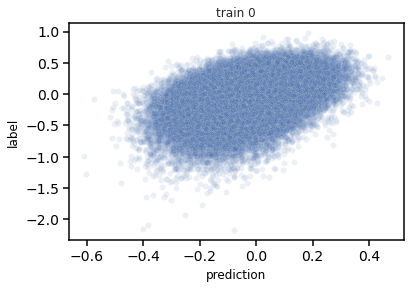

/home/ec2-user/anaconda3/envs/tensorflow2_p37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


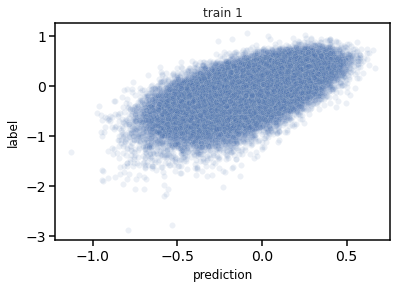

/home/ec2-user/anaconda3/envs/tensorflow2_p37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


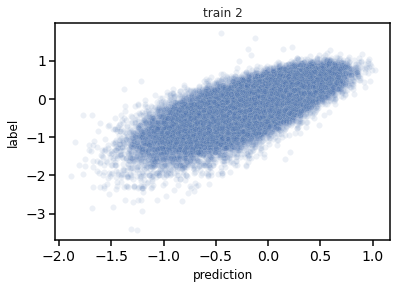

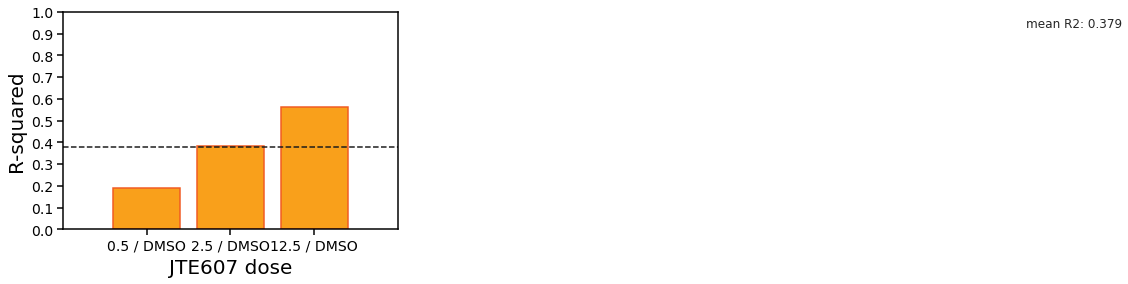

scores [0.192, 0.381, 0.563]


In [20]:
#evaluate on data 
import seaborn as sns
import scipy.stats as stats

#predict train, val, test sets 
x_preds = model.predict(data_train_x)
print(x_preds)
print(data_train_y)


scores = []
for i in range(3):
    pred = x_preds[:,i]
    obs = data_train_y[data_train_y.columns[i]]
    slope, intercept, r_value, p_value, std_err = linregress(obs,pred)
    scores.append(round(r_value**2, 3))
    
    sns.scatterplot(pred, obs, alpha = 0.1)
    plt.xlabel('prediction')
    plt.ylabel('label')
    plt.title('train %s' % (i))
    plt.savefig(output_path_prefix+"_scatter_train_%s.pdf" % (i))
    plt.show()
    relevant_metrics(pred, obs)

mean = round(np.array(scores).sum() / len(scores),3)
f, ax = plt.subplots()
ax.bar(x=["0.5 / DMSO", "2.5 / DMSO", "12.5 / DMSO"],height=scores,align='center',color='#F9A01B',edgecolor='#F15A22', linewidth=1.5)
ax.set_xticks(range(0,3));
ax.set_xlim((-1,3))

ax.set_yticks(np.arange(0,1.01,0.1))
ax.set_yticklabels([round(x,1) for x in np.arange(0,1.01,0.1)])
ax.axhline(mean, linewidth=1.5, ls='dashed', color='k')
ax.text(x=10.5, y=0.93, s='mean R2: ' + str(mean))
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xlabel('JTE607 dose', size=20)
ax.set_ylabel('R-squared', size=20)
plt.savefig(output_path_prefix+"_train_scatter.pdf")
plt.show()

print("scores", scores)


[[ 0.0752433   0.13944933  0.24204388]
 [ 0.02949724 -0.21197939 -0.63972497]
 [ 0.10729504  0.17720085  0.21812102]
 ...
 [ 0.14058566  0.22935897  0.3604882 ]
 [-0.09250106 -0.27894133 -0.6437109 ]
 [ 0.08185753  0.13348228  0.2012501 ]]
      0p5uM_percent  2p5uM_percent  12p5uM_percent
0          0.158997       0.248974        0.382862
1         -0.011128      -0.358545       -0.694788
2          0.262036       0.216982        0.345407
3          0.398708       0.543282        0.725449
4          0.235647       0.421218        0.653545
...             ...            ...             ...
2055       0.328462       0.483059        0.545658
2056       0.125522       0.073770        0.333900
2057       0.150214       0.271301        0.255428
2058       0.197842      -0.585476       -0.479392
2059       0.197842       0.014581        0.064910

[2060 rows x 3 columns]


/home/ec2-user/anaconda3/envs/tensorflow2_p37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


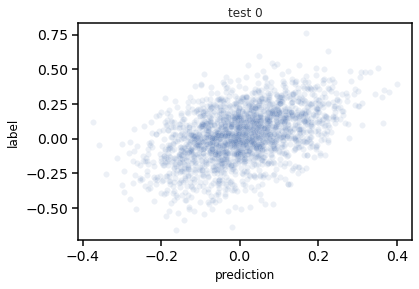

/home/ec2-user/anaconda3/envs/tensorflow2_p37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


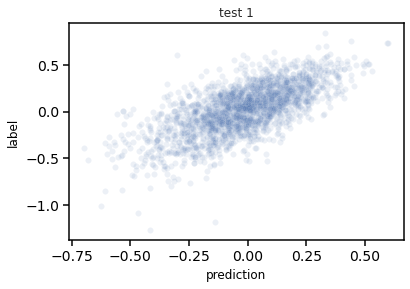

/home/ec2-user/anaconda3/envs/tensorflow2_p37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


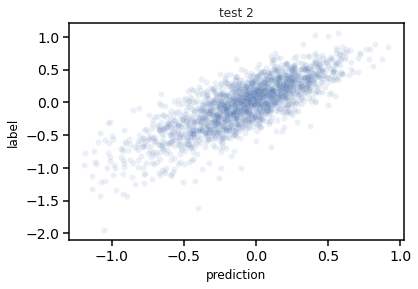

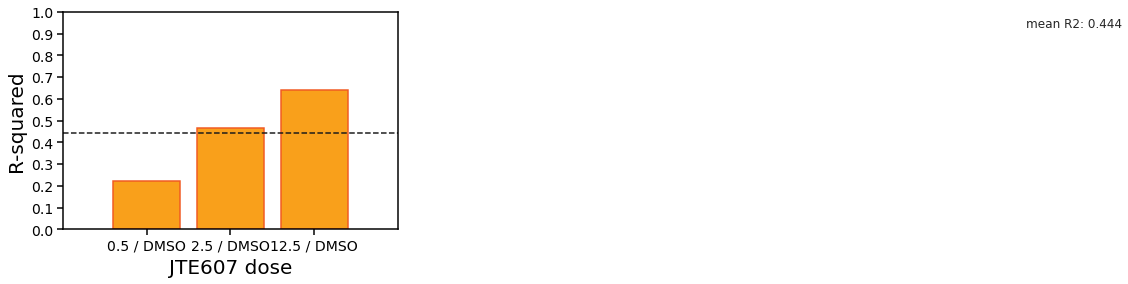

scores [0.221, 0.468, 0.642]


In [21]:
#evaluate on data 
#predict train, val, test sets 
x_preds = model.predict(data_test_x)
print(x_preds)
print(data_test_y)

scores = []
for i in range(3):
    pred = x_preds[:,i]
    obs = data_test_y[data_test_y.columns[i]]
    slope, intercept, r_value, p_value, std_err = linregress(obs,pred)
    scores.append(round(r_value**2, 3))
    
    sns.scatterplot(pred, obs, alpha = 0.1)
    plt.xlabel('prediction')
    plt.ylabel('label')
    plt.title('test %s' % (i))
    plt.savefig(output_path_prefix+"_scatter_test_%s.pdf" % (i))
    plt.show()
    relevant_metrics(pred, obs)

mean = round(np.array(scores).sum() / len(scores),3)
f, ax = plt.subplots()
ax.bar(x=["0.5 / DMSO", "2.5 / DMSO", "12.5 / DMSO"],height=scores,align='center',color='#F9A01B',edgecolor='#F15A22', linewidth=1.5)
ax.set_xticks(range(0,3));
ax.set_xlim((-1,3))

ax.set_yticks(np.arange(0,1.01,0.1))
ax.set_yticklabels([round(x,1) for x in np.arange(0,1.01,0.1)])
ax.axhline(mean, linewidth=1.5, ls='dashed', color='k')
ax.text(x=10.5, y=0.93, s='mean R2: ' + str(mean))
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xlabel('JTE607 dose', size=20)
ax.set_ylabel('R-squared', size=20)
plt.savefig(output_path_prefix+"_test_scatter.pdf")
plt.show()

print("scores", scores)
